# Gemma2-27B MLP Interpretation

This notebook analyzes how PC vectors transform through the full MLP forward pass, including nonlinear activations.

**Key Finding from Original Analysis:**
- **Layer 18 is the "smoking gun"** - shows strongest PC1 transformation effects
- Full MLP pass reveals semantic decomposition that linear analysis misses

**Approach:**
1. Run PC vectors through complete MLP (pre_ln → gate/up → down → post_ln)
2. Compare base vs instruct outputs
3. Decompose outputs onto role/trait semantic vectors
4. Focus on layer 18 for detailed interpretation

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoConfig

from chatspace.analysis import (
    load_pca_data,
    extract_pc_components,
    load_individual_role_vectors,
    load_individual_trait_vectors,
    normalize_vector,
    full_mlp_forward_batch,
    compute_z_scores
)

%matplotlib inline
sns.set_style('whitegrid')

INFO 10-16 18:27:59 [__init__.py:216] Automatically detected platform cuda.


## 1. Load Models and PC Vectors

In [2]:
# Load models (reuse from basic_weight_susceptibility or reload)
base_model_id = "google/gemma-2-27b"
instruct_model_id = "google/gemma-2-27b-it"

print("Loading models...")
config = AutoConfig.from_pretrained(base_model_id)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.bfloat16, device_map="cpu", low_cpu_mem_usage=True)
instruct_model = AutoModelForCausalLM.from_pretrained(instruct_model_id, torch_dtype=torch.bfloat16, device_map="cpu", low_cpu_mem_usage=True)
base_state_dict = {k: v.cpu() for k, v in base_model.state_dict().items()}
instruct_state_dict = {k: v.cpu() for k, v in instruct_model.state_dict().items()}
print("✓ Models loaded")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading models...


Loading checkpoint shards:   0%|          | 0/24 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

✓ Models loaded


In [3]:
# Load PCA data and extract all PCs
persona_data_root = Path("/workspace/persona-data")
roles_pca_dir = persona_data_root / "gemma-2-27b" / "roles_240" / "pca"
traits_pca_dir = persona_data_root / "gemma-2-27b" / "traits_240" / "pca"
roles_vectors_dir = persona_data_root / "gemma-2-27b" / "roles_240" / "vectors"
traits_vectors_dir = persona_data_root / "gemma-2-27b" / "traits_240" / "vectors"

pca_data, _ = load_pca_data(roles_pca_dir)
pca_layer = pca_data['layer']

# Extract ALL PCs (load 10 for flexibility)
n_pcs_total = 10
pcs_all, variance_all = extract_pc_components(pca_data, n_components=n_pcs_total)

print(f"✓ Loaded PCA data from layer {pca_layer}")
print(f"  Extracted {n_pcs_total} PCs")
print(f"  Variance explained by first 5: {variance_all[:5]}")

# Load all semantic vectors at PCA layer
role_vectors = load_individual_role_vectors(roles_vectors_dir, pca_layer)
trait_vectors = load_individual_trait_vectors(traits_vectors_dir, pca_layer)
all_semantic = {**role_vectors, **trait_vectors}

print(f"\n✓ Loaded semantic vectors:")
print(f"  {len(role_vectors)} role difference vectors")
print(f"  {len(trait_vectors)} trait contrast vectors")
print(f"  {len(all_semantic)} total semantic vectors")

/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✓ Loaded PCA data from layer 22
  Extracted 10 PCs
  Variance explained by first 5: [0.21216452 0.08200892 0.06822039 0.05221459 0.04578365]

✓ Loaded semantic vectors:
  275 role difference vectors
  240 trait contrast vectors
  506 total semantic vectors


In [4]:
# ============================================================================
# CONFIGURATION: Set analysis parameters here
# ============================================================================

# Which layers to analyze (focused on middle layers where effects are strongest)
analysis_layers = list(range(22, 27))

# Which PCs to visualize in plots
plot_pcs = ["PC1", "-PC1"]
# plot_pcs = ["PC1"]  # Uncomment to focus on PC1 only

# Number of top semantic projections to show
n_top_projections = 15

# Focus layers will be automatically identified:
# - focus_layer_absolute: Layer with biggest absolute delta (L2 norm)
# - focus_layer_angular: Layer with biggest angular delta (cosine distance)

print(f"📋 Analysis Configuration:")
print(f"  Analyzing layers: {analysis_layers[0]}-{analysis_layers[-1]}")
print(f"  Visualizing PCs: {plot_pcs}")
print(f"  Top projections to show: {n_top_projections}")
print(f"  Focus layers will be auto-identified from data")

📋 Analysis Configuration:
  Analyzing layers: 22-26
  Visualizing PCs: ['PC1', '-PC1']
  Top projections to show: 15
  Focus layers will be auto-identified from data


## 2. Full MLP Forward Pass Analysis

In [5]:
# Run MLP analysis for configured layers
mlp_results = []

print(f"Running MLP forward pass for layers {analysis_layers[0]}-{analysis_layers[-1]}...")

# Prepare input vectors (configured PCs)
input_vectors = []
vector_names = []

for pc_name in plot_pcs:
    if pc_name.startswith('-'):
        # Negative PC
        pc_idx = int(pc_name[3:]) - 1  # Extract number from "-PC1"
        vec = -pcs_all[pc_idx].float()
    else:
        # Positive PC
        pc_idx = int(pc_name[2:]) - 1  # Extract number from "PC1"
        vec = pcs_all[pc_idx]
    
    input_vectors.append(vec)
    vector_names.append(pc_name)

vectors_batch = torch.stack(input_vectors)

# Store full outputs for angular delta calculation
layer_outputs_base = {}
layer_outputs_inst = {}

for layer_num in tqdm(analysis_layers):
    # Get MLP weights
    gate_base = base_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_base = base_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_base = base_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_base = base_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_base = base_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    # Forward pass through base and instruct
    with torch.inference_mode():
        output_base = full_mlp_forward_batch(vectors_batch, gate_base, up_base, down_base, pre_ln_base, post_ln_base)
        output_inst = full_mlp_forward_batch(vectors_batch, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)
    
    # Store for angular analysis
    layer_outputs_base[layer_num] = output_base
    layer_outputs_inst[layer_num] = output_inst
    
    # Compute norms and deltas for each vector
    for i, vec_name in enumerate(vector_names):
        base_norm = output_base[i].float().norm().item()
        inst_norm = output_inst[i].float().norm().item()
        
        # Absolute delta (L2 norm of difference)
        delta_vec = output_inst[i] - output_base[i]
        delta_absolute = delta_vec.float().norm().item()
        
        # Angular delta (cosine distance)
        # Cosine similarity: (a·b) / (||a|| ||b||)
        # Cosine distance: 1 - cosine_similarity
        dot_product = (output_base[i].float() @ output_inst[i].float()).item()
        cosine_sim = dot_product / (base_norm * inst_norm + 1e-8)
        delta_angular = 1.0 - cosine_sim
        
        mlp_results.append({
            'layer': layer_num,
            'input_vector': vec_name,
            'base_output_norm': base_norm,
            'instruct_output_norm': inst_norm,
            'delta_absolute': delta_absolute,
            'delta_angular': delta_angular,
        })

mlp_df = pd.DataFrame(mlp_results)
print(f"\n✓ MLP analysis complete: {len(mlp_df)} results")

# Identify focus layers (using first PC)
first_pc = plot_pcs[0]
first_pc_data = mlp_df[mlp_df['input_vector'] == first_pc]

focus_layer_absolute_idx = first_pc_data['delta_absolute'].idxmax()
focus_layer_absolute = first_pc_data.loc[focus_layer_absolute_idx, 'layer']

focus_layer_angular_idx = first_pc_data['delta_angular'].idxmax()
focus_layer_angular = first_pc_data.loc[focus_layer_angular_idx, 'layer']

print(f"\n🎯 Focus layers identified (for {first_pc}):")
print(f"  Absolute delta (L2 norm): Layer {focus_layer_absolute} (Δ={first_pc_data.loc[focus_layer_absolute_idx, 'delta_absolute']:.4f})")
print(f"  Angular delta (cosine distance): Layer {focus_layer_angular} (Δ={first_pc_data.loc[focus_layer_angular_idx, 'delta_angular']:.4f})")

Running MLP forward pass for layers 22-26...


100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


✓ MLP analysis complete: 10 results

🎯 Focus layers identified (for PC1):
  Absolute delta (L2 norm): Layer 24 (Δ=678.7557)
  Angular delta (cosine distance): Layer 22 (Δ=0.0284)


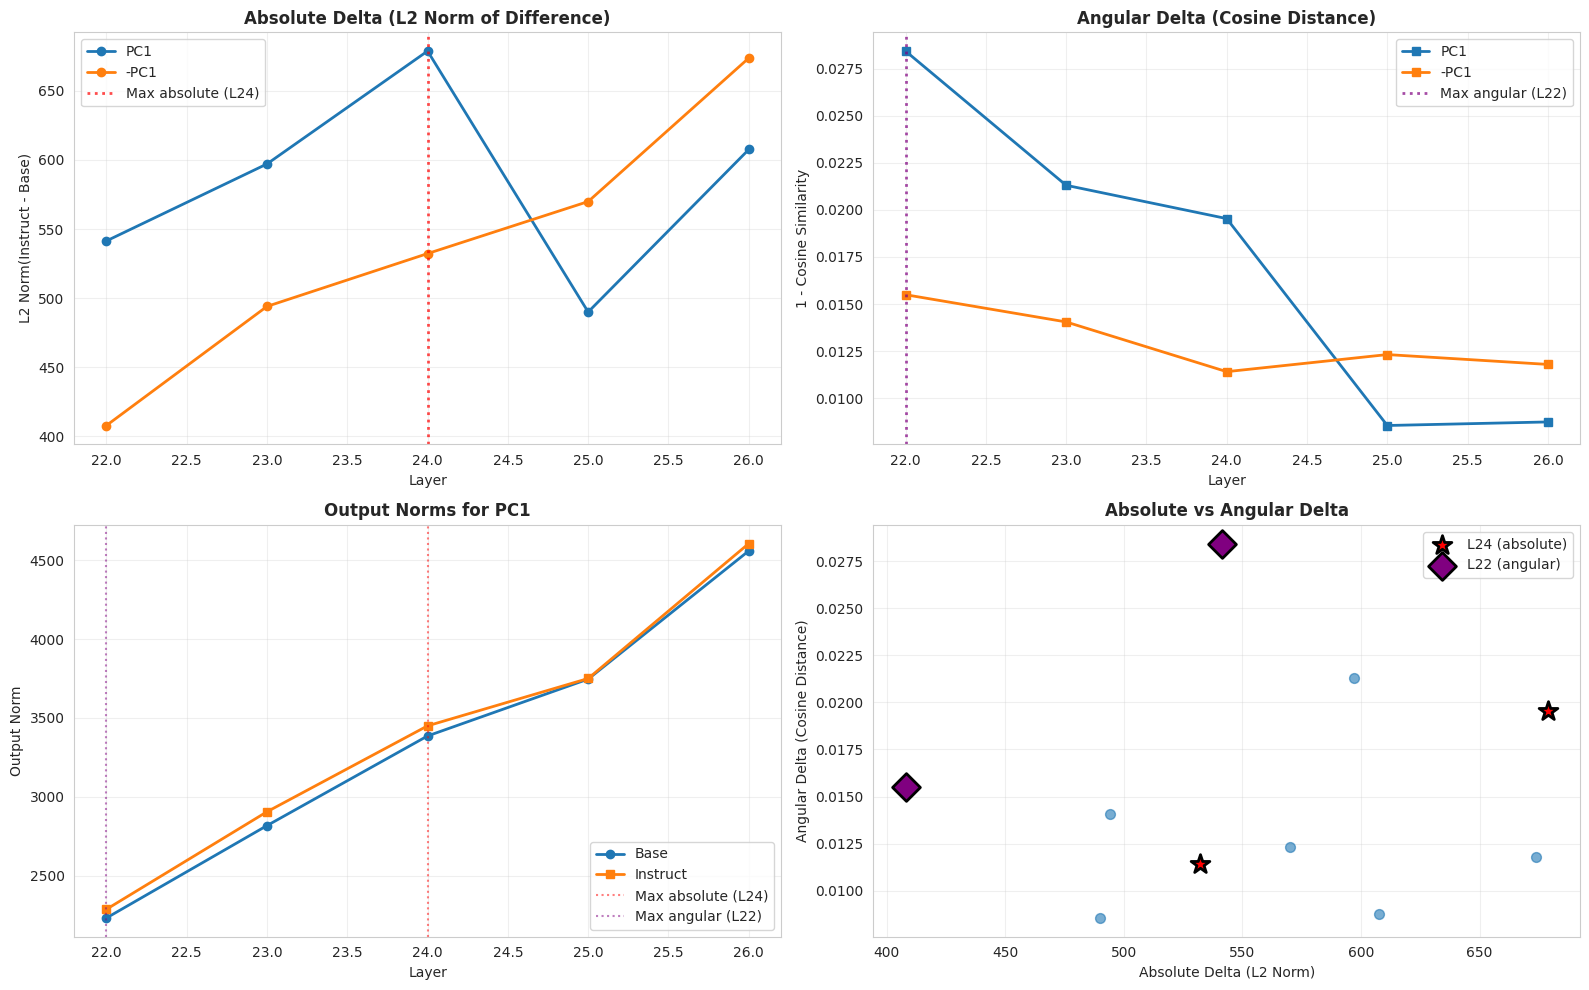


📊 Visualization shows:
  - Red markers: Layer 24 (max absolute delta)
  - Purple markers: Layer 22 (max angular delta)
  ⚠ Different layers identified - analyzing both!


In [6]:
# Visualize MLP transformation results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Absolute delta by layer (top left)
for vec_name in plot_pcs:
    data = mlp_df[mlp_df['input_vector'] == vec_name]
    axes[0, 0].plot(data['layer'], data['delta_absolute'], marker='o', label=vec_name, linewidth=2)

axes[0, 0].axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.7, linewidth=2, label=f'Max absolute (L{int(focus_layer_absolute)})')
axes[0, 0].set_title('Absolute Delta (L2 Norm of Difference)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Layer')
axes[0, 0].set_ylabel('L2 Norm(Instruct - Base)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Angular delta by layer (top right)
for vec_name in plot_pcs:
    data = mlp_df[mlp_df['input_vector'] == vec_name]
    axes[0, 1].plot(data['layer'], data['delta_angular'], marker='s', label=vec_name, linewidth=2)

axes[0, 1].axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.7, linewidth=2, label=f'Max angular (L{int(focus_layer_angular)})')
axes[0, 1].set_title('Angular Delta (Cosine Distance)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Layer')
axes[0, 1].set_ylabel('1 - Cosine Similarity')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Compare base vs instruct norms (bottom left, first PC only)
first_pc = plot_pcs[0]
pc_data = mlp_df[mlp_df['input_vector'] == first_pc]
axes[1, 0].plot(pc_data['layer'], pc_data['base_output_norm'], marker='o', label='Base', linewidth=2, color='C0')
axes[1, 0].plot(pc_data['layer'], pc_data['instruct_output_norm'], marker='s', label='Instruct', linewidth=2, color='C1')
axes[1, 0].axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.5, label=f'Max absolute (L{int(focus_layer_absolute)})')
axes[1, 0].axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.5, label=f'Max angular (L{int(focus_layer_angular)})')
axes[1, 0].set_title(f'Output Norms for {first_pc}', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Layer')
axes[1, 0].set_ylabel('Output Norm')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter: Absolute vs Angular delta (bottom right)
axes[1, 1].scatter(mlp_df['delta_absolute'], mlp_df['delta_angular'], alpha=0.6, s=50)
# Highlight focus layers
for vec_name in plot_pcs:
    vec_data = mlp_df[mlp_df['input_vector'] == vec_name]
    abs_focus = vec_data[vec_data['layer'] == focus_layer_absolute]
    ang_focus = vec_data[vec_data['layer'] == focus_layer_angular]
    
    if not abs_focus.empty:
        axes[1, 1].scatter(abs_focus['delta_absolute'], abs_focus['delta_angular'], 
                          color='red', s=200, marker='*', edgecolors='black', linewidths=2, 
                          label=f'L{int(focus_layer_absolute)} (absolute)' if vec_name == first_pc else '')
    if not ang_focus.empty:
        axes[1, 1].scatter(ang_focus['delta_absolute'], ang_focus['delta_angular'], 
                          color='purple', s=200, marker='D', edgecolors='black', linewidths=2,
                          label=f'L{int(focus_layer_angular)} (angular)' if vec_name == first_pc else '')

axes[1, 1].set_title('Absolute vs Angular Delta', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Absolute Delta (L2 Norm)')
axes[1, 1].set_ylabel('Angular Delta (Cosine Distance)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Visualization shows:")
print(f"  - Red markers: Layer {int(focus_layer_absolute)} (max absolute delta)")
print(f"  - Purple markers: Layer {int(focus_layer_angular)} (max angular delta)")
if focus_layer_absolute == focus_layer_angular:
    print(f"  ✓ Both metrics identify the same layer!")
else:
    print(f"  ⚠ Different layers identified - analyzing both!")

## 3. Semantic Decomposition at Focus Layers

Decompose what instruction tuning adds at both focus layers:
- **Absolute focus layer**: Where magnitude change is largest
- **Angular focus layer**: Where direction change is largest

In [7]:
def analyze_focus_layer(layer_num, layer_name, first_pc_name, pc_idx):
    """Analyze semantic decomposition at a focus layer."""
    print(f"\n{'='*80}")
    print(f"{layer_name.upper()}: Layer {layer_num}")
    print(f"{'='*80}")
    
    # Get PC vector
    if first_pc_name.startswith('-'):
        pc_vec = -pcs_all[pc_idx].float()
    else:
        pc_vec = pcs_all[pc_idx]
    
    # Get MLP weights
    gate_base = base_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_base = base_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_base = base_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_base = base_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_base = base_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    with torch.inference_mode():
        pc_batch = pc_vec.unsqueeze(0)
        output_base = full_mlp_forward_batch(pc_batch, gate_base, up_base, down_base, pre_ln_base, post_ln_base)[0]
        output_inst = full_mlp_forward_batch(pc_batch, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)[0]
    
    # Compute difference
    difference = output_inst - output_base
    
    # Compute metrics
    base_norm = output_base.float().norm().item()
    inst_norm = output_inst.float().norm().item()
    diff_norm = difference.float().norm().item()
    
    dot_product = (output_base.float() @ output_inst.float()).item()
    cosine_sim = dot_product / (base_norm * inst_norm + 1e-8)
    cosine_dist = 1.0 - cosine_sim
    
    print(f"\n{first_pc_name} MLP transformation:")
    print(f"  Base output norm: {base_norm:.4f}")
    print(f"  Instruct output norm: {inst_norm:.4f}")
    print(f"  Absolute delta (L2): {diff_norm:.4f}")
    print(f"  Angular delta (cosine dist): {cosine_dist:.4f}")
    
    # Project difference onto semantic vectors
    semantic_names = list(all_semantic.keys())
    projections = {}
    for name in semantic_names:
        vec = all_semantic[name]
        proj = (difference.float() @ vec.float()).item()
        projections[name] = proj
    
    # Sort by strength
    sorted_projs = sorted(projections.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print(f"\n🔍 Top {n_top_projections} semantic projections (what instruction tuning adds):")
    print("-"*80)
    for name, proj in sorted_projs[:n_top_projections]:
        print(f"{proj:+.4f}  {name}")
    
    print(f"\n🔍 Bottom {n_top_projections} semantic projections:")
    print("-"*80)
    for name, proj in sorted_projs[-n_top_projections:]:
        print(f"{proj:+.4f}  {name}")
    
    return sorted_projs

# Prepare PC info
first_pc_name = plot_pcs[0]
if first_pc_name.startswith('-'):
    pc_idx = int(first_pc_name[3:]) - 1
else:
    pc_idx = int(first_pc_name[2:]) - 1

In [8]:
# Analyze absolute focus layer
projections_absolute = analyze_focus_layer(
    int(focus_layer_absolute),
    "ABSOLUTE FOCUS LAYER",
    first_pc_name,
    pc_idx
)


ABSOLUTE FOCUS LAYER: Layer 24

PC1 MLP transformation:
  Base output norm: 3386.0586
  Instruct output norm: 3450.4001
  Absolute delta (L2): 677.9233
  Angular delta (cosine dist): 0.0195

🔍 Top 15 semantic projections (what instruction tuning adds):
--------------------------------------------------------------------------------
-387.2055  poet
-387.2017  poetic
-378.3598  pirate
-365.1915  bard
-359.6892  grandparent
-358.5293  jester
-355.9594  provincial
-355.3169  prisoner
-354.9160  narrator
-354.6192  celebrity
-354.3450  criminal
-354.0408  blogger
-354.0311  auctioneer
-352.6799  survivor
-348.8299  elder

🔍 Bottom 15 semantic projections:
--------------------------------------------------------------------------------
+16.2677  data_driven
+13.4563  erudite
+13.2695  lawyer
+13.2139  cyborg
+12.4775  proofreader
-12.0521  sociologist
+10.9182  negotiator
-10.7981  proactive
+9.9051  closure_seeking
-5.5777  pragmatist
-4.5826  interviewer
+3.5088  divergent
+3.0071  skepti

In [9]:
# Analyze angular focus layer
projections_angular = analyze_focus_layer(
    int(focus_layer_angular),
    "ANGULAR FOCUS LAYER",
    first_pc_name,
    pc_idx
)


ANGULAR FOCUS LAYER: Layer 22



PC1 MLP transformation:
  Base output norm: 2230.5806
  Instruct output norm: 2286.3699
  Absolute delta (L2): 543.4191
  Angular delta (cosine dist): 0.0286

🔍 Top 15 semantic projections (what instruction tuning adds):
--------------------------------------------------------------------------------
-350.5132  poet
-339.9663  pirate
-336.8830  poetic
-324.2229  bard
-324.1816  provincial
-321.0177  blogger
-319.6063  grandparent
-318.3584  auctioneer
-317.8522  jester
-314.7092  criminal
-314.6360  prisoner
-313.6805  narrator
-309.8664  survivor
-308.9263  retiree
-308.7648  surfer

🔍 Bottom 15 semantic projections:
--------------------------------------------------------------------------------
-8.5986  anthropologist
+7.7525  summarizer
+7.1687  open_ended
+5.5179  generalist
-5.2865  sociologist
+5.1154  data_driven
+5.0243  decisive
-4.8071  literal
-4.2476  generous
+3.9045  pragmatist
-3.3865  experiential
-3.0080  meditative
+1.8790  linguist
+0.8100  existentialist
+0.1737  

## 3.5. Extended Analysis: All Semantic Vectors

Analyze how instruction tuning affects all role and trait vectors, and examine PC self-reinforcement patterns.

In [10]:
# Run all semantic vectors through MLP at both focus layers
print(f"Computing MLP transformations for {len(all_semantic)} semantic vectors...")
print(f"  Analyzing at absolute focus layer: {int(focus_layer_absolute)}")
print(f"  Analyzing at angular focus layer: {int(focus_layer_angular)}")

semantic_results = []

# Prepare all semantic vectors
semantic_names = list(all_semantic.keys())
semantic_vectors = torch.stack([all_semantic[name] for name in semantic_names])

for layer_num in [int(focus_layer_absolute), int(focus_layer_angular)]:
    # Get MLP weights
    gate_base = base_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_base = base_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_base = base_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_base = base_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_base = base_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    with torch.inference_mode():
        outputs_base = full_mlp_forward_batch(semantic_vectors, gate_base, up_base, down_base, pre_ln_base, post_ln_base)
        outputs_inst = full_mlp_forward_batch(semantic_vectors, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)
    
    # Compute deltas for each semantic vector
    for i, name in enumerate(semantic_names):
        base_norm = outputs_base[i].float().norm().item()
        inst_norm = outputs_inst[i].float().norm().item()
        
        # Absolute delta
        delta_vec = outputs_inst[i] - outputs_base[i]
        delta_absolute = delta_vec.float().norm().item()
        
        # Angular delta
        dot_product = (outputs_base[i].float() @ outputs_inst[i].float()).item()
        cosine_sim = dot_product / (base_norm * inst_norm + 1e-8)
        delta_angular = 1.0 - cosine_sim
        
        # Determine type
        if name in role_vectors:
            vec_type = "role"
        elif name in trait_vectors:
            vec_type = "trait"
        else:
            vec_type = "other"
        
        semantic_results.append({
            'name': name,
            'type': vec_type,
            'layer': layer_num,
            'layer_type': 'absolute' if layer_num == int(focus_layer_absolute) else 'angular',
            'delta_absolute': delta_absolute,
            'delta_angular': delta_angular,
        })

semantic_df = pd.DataFrame(semantic_results)
print(f"\n✓ Computed transformations for {len(semantic_names)} vectors at 2 layers")
print(f"  Total results: {len(semantic_df)}")

Computing MLP transformations for 506 semantic vectors...
  Analyzing at absolute focus layer: 24
  Analyzing at angular focus layer: 22

✓ Computed transformations for 506 vectors at 2 layers
  Total results: 1012


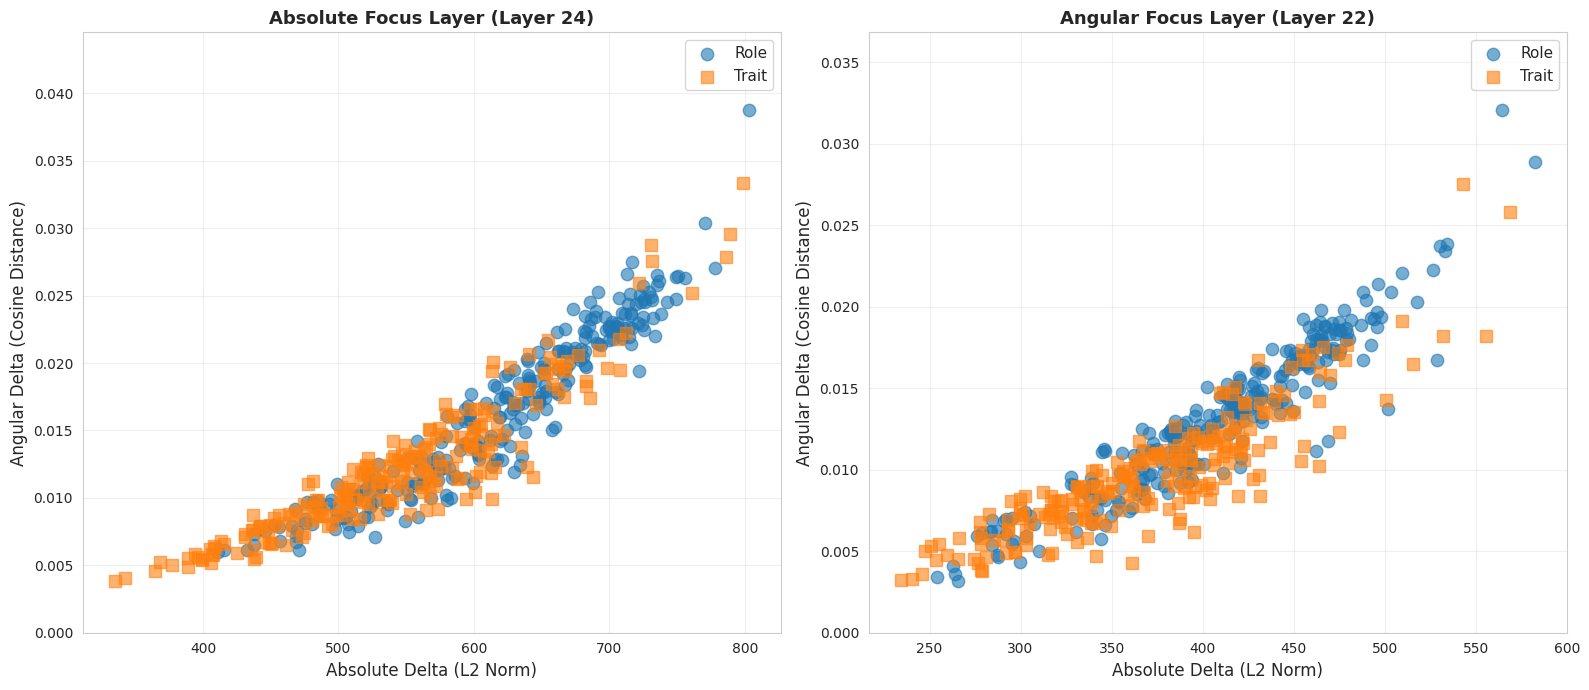


📊 Semantic Vector Shift Statistics:

Absolute Focus Layer (L24):
  Roles (n=275):
    Absolute delta: 616.6328 ± 82.8892
      Range: [411.3256, 803.3220]
    Angular delta: 0.016443 ± 0.005943
      Range: [0.005955, 0.038736]
    Correlation (abs vs ang): 0.947
  Traits (n=231):
    Absolute delta: 545.8741 ± 87.3656
      Range: [334.6776, 798.5318]
    Angular delta: 0.012295 ± 0.004991
      Range: [0.003866, 0.033382]
    Correlation (abs vs ang): 0.922

Angular Focus Layer (L22):
  Roles (n=275):
    Absolute delta: 408.5195 ± 60.9516
      Range: [253.9080, 582.6788]
    Angular delta: 0.013229 ± 0.004563
      Range: [0.003202, 0.032057]
    Correlation (abs vs ang): 0.941
  Traits (n=231):
    Absolute delta: 371.0461 ± 62.4818
      Range: [234.0648, 568.7554]
    Angular delta: 0.009772 ± 0.003689
      Range: [0.003246, 0.027516]
    Correlation (abs vs ang): 0.878


In [11]:
# Scatter plot: Traits and Roles by shift magnitude
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for layer_idx, (layer_num, layer_type) in enumerate([
    (int(focus_layer_absolute), 'Absolute Focus Layer'),
    (int(focus_layer_angular), 'Angular Focus Layer')
]):
    ax = axes[layer_idx]
    layer_data = semantic_df[semantic_df['layer'] == layer_num]
    
    # Plot roles and traits separately
    for vec_type, color, marker in [('role', 'C0', 'o'), ('trait', 'C1', 's')]:
        data = layer_data[layer_data['type'] == vec_type]
        ax.scatter(data['delta_absolute'], data['delta_angular'], 
                  alpha=0.6, s=80, color=color, marker=marker, label=vec_type.capitalize())
    
    ax.set_xlabel('Absolute Delta (L2 Norm)', fontsize=12)
    ax.set_ylabel('Angular Delta (Cosine Distance)', fontsize=12)
    ax.set_title(f'{layer_type} (Layer {layer_num})', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Set reasonable y-axis limit for cosine distance
    ax.set_ylim(bottom=0, top=min(1.0, ax.get_ylim()[1] * 1.1))

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 Semantic Vector Shift Statistics:")
for layer_num, layer_type in [
    (int(focus_layer_absolute), 'Absolute'),
    (int(focus_layer_angular), 'Angular')
]:
    layer_data = semantic_df[semantic_df['layer'] == layer_num]
    print(f"\n{layer_type} Focus Layer (L{layer_num}):")
    for vec_type in ['role', 'trait']:
        data = layer_data[layer_data['type'] == vec_type]
        print(f"  {vec_type.capitalize()}s (n={len(data)}):")
        print(f"    Absolute delta: {data['delta_absolute'].mean():.4f} ± {data['delta_absolute'].std():.4f}")
        print(f"      Range: [{data['delta_absolute'].min():.4f}, {data['delta_absolute'].max():.4f}]")
        print(f"    Angular delta: {data['delta_angular'].mean():.6f} ± {data['delta_angular'].std():.6f}")
        print(f"      Range: [{data['delta_angular'].min():.6f}, {data['delta_angular'].max():.6f}]")
        print(f"    Correlation (abs vs ang): {data['delta_absolute'].corr(data['delta_angular']):.3f}")

In [12]:
# Compute all semantic vectors across ALL analysis layers (not just focus layers)
print(f"Computing transformations for {len(all_semantic)} semantic vectors across {len(analysis_layers)} layers...")

semantic_all_layers = []

for layer_num in tqdm(analysis_layers, desc="Processing layers"):
    # Get MLP weights
    gate_base = base_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_base = base_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_base = base_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_base = base_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_base = base_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    with torch.inference_mode():
        outputs_base = full_mlp_forward_batch(semantic_vectors, gate_base, up_base, down_base, pre_ln_base, post_ln_base)
        outputs_inst = full_mlp_forward_batch(semantic_vectors, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)
    
    # Compute deltas for each semantic vector
    for i, name in enumerate(semantic_names):
        base_norm = outputs_base[i].float().norm().item()
        inst_norm = outputs_inst[i].float().norm().item()
        
        # Absolute delta
        delta_vec = outputs_inst[i] - outputs_base[i]
        delta_absolute = delta_vec.float().norm().item()
        
        # Angular delta
        dot_product = (outputs_base[i].float() @ outputs_inst[i].float()).item()
        cosine_sim = dot_product / (base_norm * inst_norm + 1e-8)
        delta_angular = 1.0 - cosine_sim
        
        # Determine type
        if name in role_vectors:
            vec_type = "role"
        elif name in trait_vectors:
            vec_type = "trait"
        else:
            vec_type = "other"
        
        semantic_all_layers.append({
            'name': name,
            'type': vec_type,
            'layer': layer_num,
            'delta_absolute': delta_absolute,
            'delta_angular': delta_angular,
        })

semantic_all_df = pd.DataFrame(semantic_all_layers)
print(f"\n✓ Computed {len(semantic_all_df)} measurements ({len(semantic_names)} vectors × {len(analysis_layers)} layers)")

Computing transformations for 506 semantic vectors across 5 layers...


Processing layers: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


✓ Computed 2530 measurements (506 vectors × 5 layers)


In [13]:
# Aggregate across layers: compute mean delta for each semantic vector
semantic_agg = semantic_all_df.groupby(['name', 'type']).agg({
    'delta_absolute': ['mean', 'std', 'max'],
    'delta_angular': ['mean', 'std', 'max']
}).reset_index()

# Flatten column names
semantic_agg.columns = ['name', 'type', 'abs_mean', 'abs_std', 'abs_max', 'ang_mean', 'ang_std', 'ang_max']

# Sort by mean absolute delta
semantic_agg_sorted = semantic_agg.sort_values('abs_mean', ascending=False)

print("="*80)
print("MOST ALTERED SEMANTIC VECTORS (by mean absolute delta across layers)")
print("="*80)

print(f"\n🔴 Top 15 Roles:")
top_roles = semantic_agg_sorted[semantic_agg_sorted['type'] == 'role'].head(15)
for idx, row in top_roles.iterrows():
    print(f"  {row['name']:30s} | Abs: {row['abs_mean']:.4f} ± {row['abs_std']:.4f} | Ang: {row['ang_mean']:.6f} ± {row['ang_std']:.6f}")

print(f"\n🟠 Top 15 Traits:")
top_traits = semantic_agg_sorted[semantic_agg_sorted['type'] == 'trait'].head(15)
for idx, row in top_traits.iterrows():
    print(f"  {row['name']:30s} | Abs: {row['abs_mean']:.4f} ± {row['abs_std']:.4f} | Ang: {row['ang_mean']:.6f} ± {row['ang_std']:.6f}")

# Also sort by angular delta
print("\n" + "="*80)
print("MOST ALTERED SEMANTIC VECTORS (by mean angular delta across layers)")
print("="*80)

semantic_agg_ang = semantic_agg.sort_values('ang_mean', ascending=False)

print(f"\n🔴 Top 10 Roles (by direction change):")
top_roles_ang = semantic_agg_ang[semantic_agg_ang['type'] == 'role'].head(10)
for idx, row in top_roles_ang.iterrows():
    print(f"  {row['name']:30s} | Ang: {row['ang_mean']:.6f} | Abs: {row['abs_mean']:.4f}")

print(f"\n🟠 Top 10 Traits (by direction change):")
top_traits_ang = semantic_agg_ang[semantic_agg_ang['type'] == 'trait'].head(10)
for idx, row in top_traits_ang.iterrows():
    print(f"  {row['name']:30s} | Ang: {row['ang_mean']:.6f} | Abs: {row['abs_mean']:.4f}")

MOST ALTERED SEMANTIC VECTORS (by mean absolute delta across layers)

🔴 Top 15 Roles:
  poet                           | Abs: 702.9874 ± 94.5340 | Ang: 0.026925 ± 0.012664
  playwright                     | Abs: 645.8242 ± 81.1904 | Ang: 0.019018 ± 0.008126
  narrator                       | Abs: 641.9270 ± 105.5417 | Ang: 0.018680 ± 0.007255
  pirate                         | Abs: 628.5966 ± 120.6372 | Ang: 0.018522 ± 0.007924
  auctioneer                     | Abs: 627.2079 ± 115.7400 | Ang: 0.017095 ± 0.006489
  jester                         | Abs: 626.1866 ± 109.1656 | Ang: 0.017560 ± 0.007153
  witness                        | Abs: 626.1070 ± 99.7204 | Ang: 0.017311 ± 0.006428
  provincial                     | Abs: 621.4470 ± 130.8985 | Ang: 0.017557 ± 0.005849
  exile                          | Abs: 621.2293 ± 113.4547 | Ang: 0.017264 ± 0.006344
  actor                          | Abs: 618.3280 ± 110.2542 | Ang: 0.016467 ± 0.005934
  novelist                       | Abs: 616.779

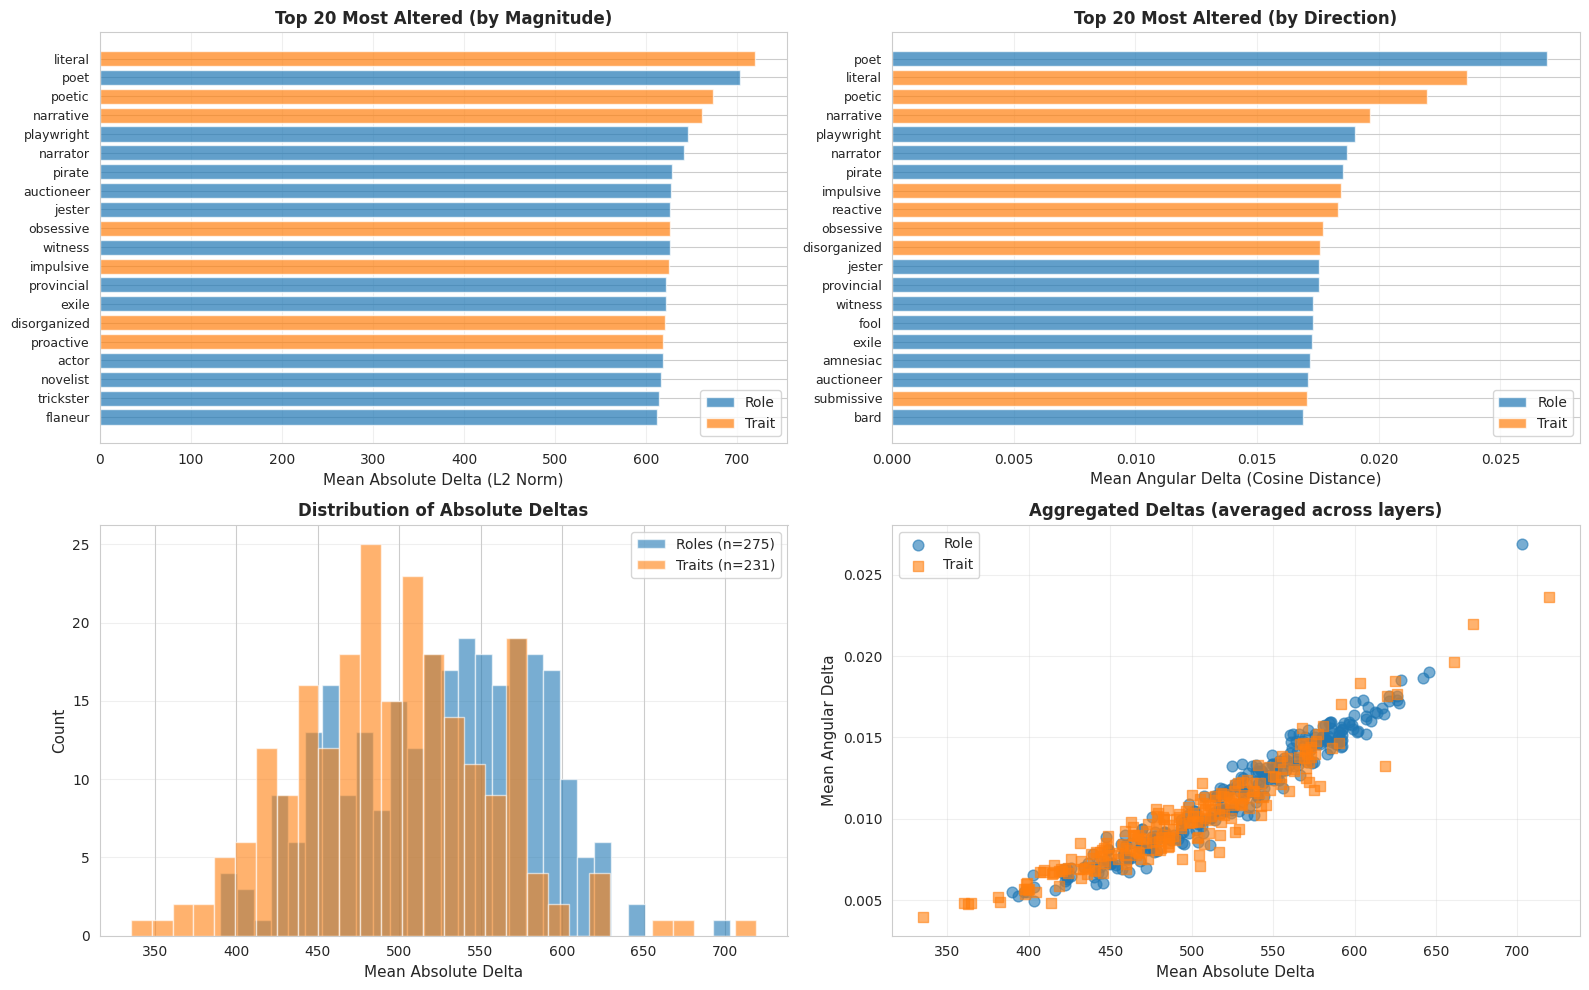


📊 Summary Statistics (integrated across 5 layers):

Roles:
  Mean absolute delta: 526.2650 ± 58.3728
  Range: [389.9386, 702.9874]

Traits:
  Mean absolute delta: 495.9253 ± 59.6709
  Range: [335.4262, 719.1688]

T-test (roles vs traits): t=5.765, p=0.0000
  → Roles are significantly MORE altered than traits


In [14]:
# Visualize top altered semantic vectors
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top left: Top 20 by absolute delta
ax = axes[0, 0]
top_20_abs = semantic_agg_sorted.head(20)
colors = ['C0' if t == 'role' else 'C1' for t in top_20_abs['type']]
y_pos = np.arange(len(top_20_abs))
ax.barh(y_pos, top_20_abs['abs_mean'], color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20_abs['name'], fontsize=9)
ax.set_xlabel('Mean Absolute Delta (L2 Norm)', fontsize=11)
ax.set_title('Top 20 Most Altered (by Magnitude)', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='C0', alpha=0.7, label='Role'),
                   Patch(facecolor='C1', alpha=0.7, label='Trait')]
ax.legend(handles=legend_elements, fontsize=10)

# Top right: Top 20 by angular delta
ax = axes[0, 1]
top_20_ang = semantic_agg_ang.head(20)
colors = ['C0' if t == 'role' else 'C1' for t in top_20_ang['type']]
y_pos = np.arange(len(top_20_ang))
ax.barh(y_pos, top_20_ang['ang_mean'], color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20_ang['name'], fontsize=9)
ax.set_xlabel('Mean Angular Delta (Cosine Distance)', fontsize=11)
ax.set_title('Top 20 Most Altered (by Direction)', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
ax.legend(handles=legend_elements, fontsize=10)

# Bottom left: Distribution comparison
ax = axes[1, 0]
role_means = semantic_agg[semantic_agg['type'] == 'role']['abs_mean']
trait_means = semantic_agg[semantic_agg['type'] == 'trait']['abs_mean']
ax.hist(role_means, bins=30, alpha=0.6, color='C0', label=f'Roles (n={len(role_means)})')
ax.hist(trait_means, bins=30, alpha=0.6, color='C1', label=f'Traits (n={len(trait_means)})')
ax.set_xlabel('Mean Absolute Delta', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of Absolute Deltas', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Bottom right: Scatter of aggregated values
ax = axes[1, 1]
for vec_type, color, marker in [('role', 'C0', 'o'), ('trait', 'C1', 's')]:
    data = semantic_agg[semantic_agg['type'] == vec_type]
    ax.scatter(data['abs_mean'], data['ang_mean'], 
              alpha=0.6, s=60, color=color, marker=marker, label=vec_type.capitalize())

ax.set_xlabel('Mean Absolute Delta', fontsize=11)
ax.set_ylabel('Mean Angular Delta', fontsize=11)
ax.set_title('Aggregated Deltas (averaged across layers)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary stats
print(f"\n📊 Summary Statistics (integrated across {len(analysis_layers)} layers):")
print(f"\nRoles:")
print(f"  Mean absolute delta: {role_means.mean():.4f} ± {role_means.std():.4f}")
print(f"  Range: [{role_means.min():.4f}, {role_means.max():.4f}]")
print(f"\nTraits:")
print(f"  Mean absolute delta: {trait_means.mean():.4f} ± {trait_means.std():.4f}")
print(f"  Range: [{trait_means.min():.4f}, {trait_means.max():.4f}]")

# Statistical test
from scipy import stats
t_stat, p_value = stats.ttest_ind(role_means, trait_means)
print(f"\nT-test (roles vs traits): t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    if role_means.mean() > trait_means.mean():
        print("  → Roles are significantly MORE altered than traits")
    else:
        print("  → Traits are significantly MORE altered than roles")
else:
    print("  → No significant difference between roles and traits")

## 3.6. PC Self-Reinforcement Analysis

Analyze whether PCs and their negatives tend to strengthen themselves (self-bias in outputs).

In [15]:
# Analyze PC self-reinforcement
# For each PC, measure how much the output projects back onto itself
print(f"Analyzing PC self-reinforcement across layers {analysis_layers[0]}-{analysis_layers[-1]}...")

pc_reinforcement_results = []

# Test PCs and their negatives
pc_test_vectors = []
pc_test_names = []

for pc_idx in range(min(5, n_pcs_total)):  # Test first 5 PCs
    pc_name = f"PC{pc_idx+1}"
    pc_test_vectors.append(pcs_all[pc_idx])
    pc_test_names.append(pc_name)
    
    pc_test_vectors.append(-pcs_all[pc_idx].float())
    pc_test_names.append(f"-{pc_name}")

pc_test_batch = torch.stack(pc_test_vectors)

for layer_num in tqdm(analysis_layers, desc="Computing self-reinforcement"):
    # Get MLP weights
    gate_base = base_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_base = base_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_base = base_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_base = base_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_base = base_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    with torch.inference_mode():
        outputs_base = full_mlp_forward_batch(pc_test_batch, gate_base, up_base, down_base, pre_ln_base, post_ln_base)
        outputs_inst = full_mlp_forward_batch(pc_test_batch, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)
    
    # Compute self-projection for each PC
    for i, pc_name in enumerate(pc_test_names):
        input_vec = pc_test_batch[i]
        
        # Project outputs onto input direction
        input_norm = input_vec.float().norm()
        
        proj_base = (outputs_base[i].float() @ input_vec.float()).item() / (input_norm.item() + 1e-8)
        proj_inst = (outputs_inst[i].float() @ input_vec.float()).item() / (input_norm.item() + 1e-8)
        
        # Also compute orthogonal component (how much output is NOT in input direction)
        output_base_norm = outputs_base[i].float().norm().item()
        output_inst_norm = outputs_inst[i].float().norm().item()
        
        ortho_base = np.sqrt(max(0, output_base_norm**2 - proj_base**2))
        ortho_inst = np.sqrt(max(0, output_inst_norm**2 - proj_inst**2))
        
        pc_reinforcement_results.append({
            'pc': pc_name,
            'layer': layer_num,
            'proj_base': proj_base,
            'proj_inst': proj_inst,
            'proj_delta': proj_inst - proj_base,
            'ortho_base': ortho_base,
            'ortho_inst': ortho_inst,
            'ortho_delta': ortho_inst - ortho_base,
        })

pc_reinforce_df = pd.DataFrame(pc_reinforcement_results)
print(f"\n✓ Computed self-reinforcement for {len(pc_test_names)} PCs across {len(analysis_layers)} layers")

Analyzing PC self-reinforcement across layers 22-26...


Computing self-reinforcement: 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


✓ Computed self-reinforcement for 10 PCs across 5 layers


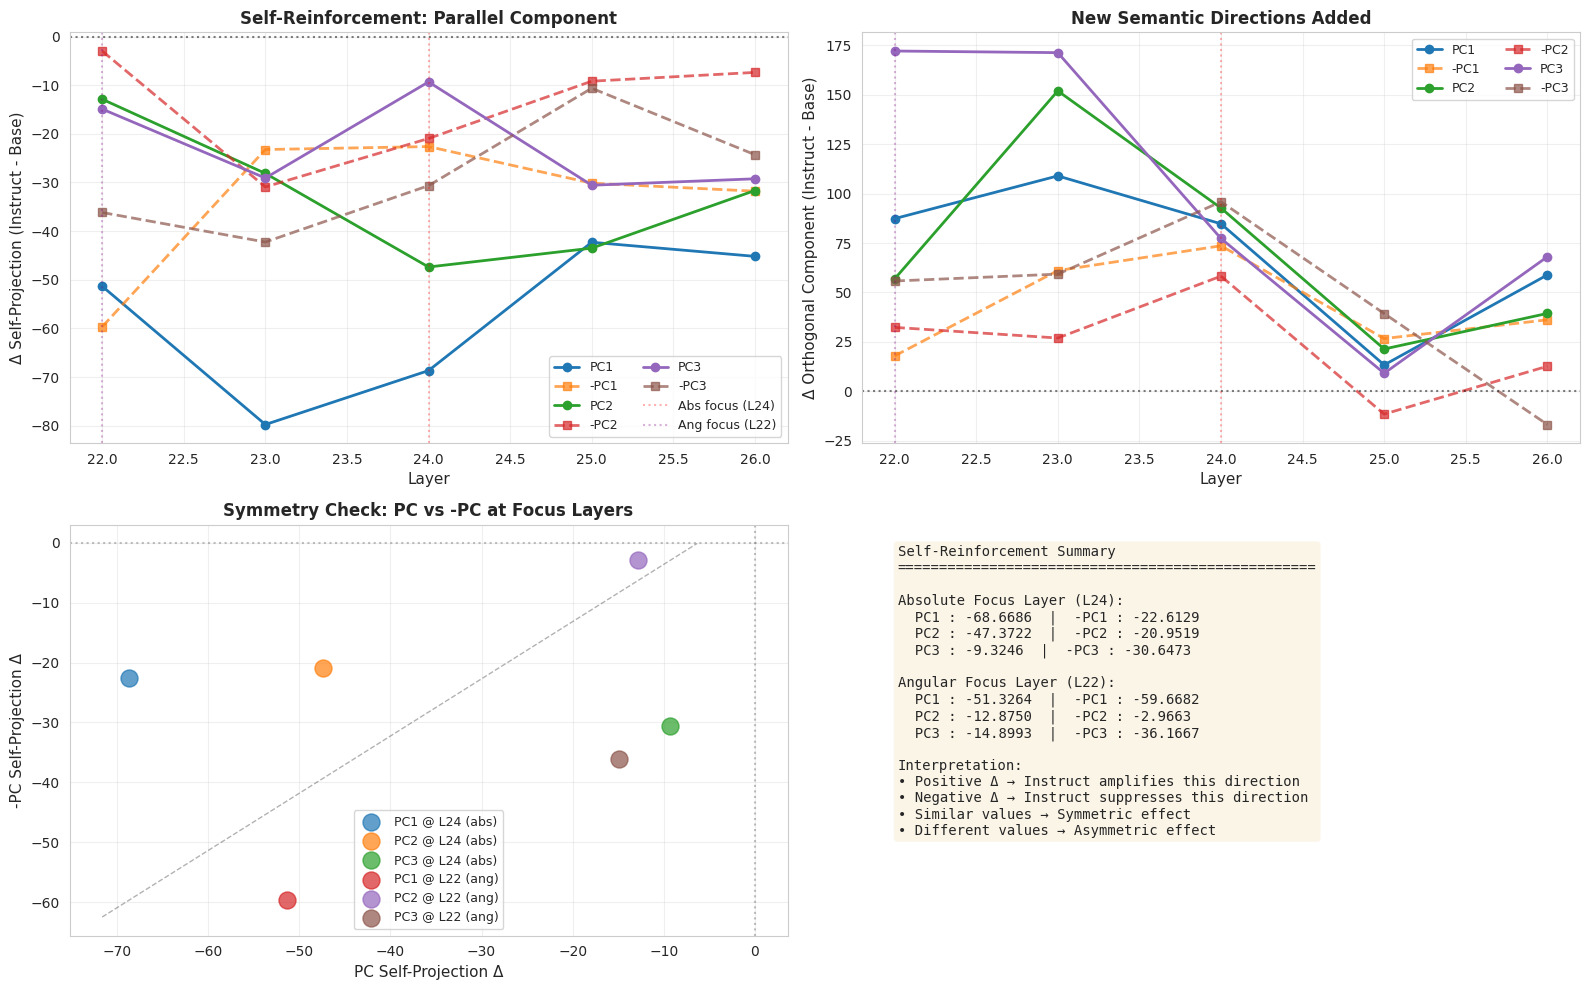

In [16]:
# Visualize PC self-reinforcement patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Get unique PC pairs (PC1 vs -PC1, etc.)
unique_pcs = sorted(set([name.replace('-', '') for name in pc_test_names]))

# Top left: Self-projection delta (parallel component change)
ax = axes[0, 0]
for pc in unique_pcs[:3]:  # Show first 3 PCs
    pos_data = pc_reinforce_df[pc_reinforce_df['pc'] == pc]
    neg_data = pc_reinforce_df[pc_reinforce_df['pc'] == f'-{pc}']
    
    ax.plot(pos_data['layer'], pos_data['proj_delta'], 'o-', label=f'{pc}', linewidth=2)
    ax.plot(neg_data['layer'], neg_data['proj_delta'], 's--', label=f'-{pc}', linewidth=2, alpha=0.7)

ax.axhline(0, color='black', linestyle=':', alpha=0.5)
ax.axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.3, label=f'Abs focus (L{int(focus_layer_absolute)})')
ax.axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.3, label=f'Ang focus (L{int(focus_layer_angular)})')
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Δ Self-Projection (Instruct - Base)', fontsize=11)
ax.set_title('Self-Reinforcement: Parallel Component', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

# Top right: Orthogonal component delta (how much new directions added)
ax = axes[0, 1]
for pc in unique_pcs[:3]:
    pos_data = pc_reinforce_df[pc_reinforce_df['pc'] == pc]
    neg_data = pc_reinforce_df[pc_reinforce_df['pc'] == f'-{pc}']
    
    ax.plot(pos_data['layer'], pos_data['ortho_delta'], 'o-', label=f'{pc}', linewidth=2)
    ax.plot(neg_data['layer'], neg_data['ortho_delta'], 's--', label=f'-{pc}', linewidth=2, alpha=0.7)

ax.axhline(0, color='black', linestyle=':', alpha=0.5)
ax.axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.3)
ax.axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.3)
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Δ Orthogonal Component (Instruct - Base)', fontsize=11)
ax.set_title('New Semantic Directions Added', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

# Bottom left: Compare PC1 vs -PC1 at focus layers
ax = axes[1, 0]
focus_layers_to_show = [int(focus_layer_absolute), int(focus_layer_angular)]
for layer_num in focus_layers_to_show:
    for pc in unique_pcs[:3]:
        pos_val = pc_reinforce_df[(pc_reinforce_df['pc'] == pc) & (pc_reinforce_df['layer'] == layer_num)]['proj_delta'].values[0]
        neg_val = pc_reinforce_df[(pc_reinforce_df['pc'] == f'-{pc}') & (pc_reinforce_df['layer'] == layer_num)]['proj_delta'].values[0]
        
        layer_label = f"L{layer_num} ({'abs' if layer_num == int(focus_layer_absolute) else 'ang'})"
        ax.scatter([pos_val], [neg_val], s=150, label=f'{pc} @ {layer_label}', alpha=0.7)

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--', alpha=0.3, linewidth=1)
ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('PC Self-Projection Δ', fontsize=11)
ax.set_ylabel('-PC Self-Projection Δ', fontsize=11)
ax.set_title('Symmetry Check: PC vs -PC at Focus Layers', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Bottom right: Summary table
ax = axes[1, 1]
ax.axis('off')

# Create summary text
summary_text = "Self-Reinforcement Summary\n" + "="*50 + "\n\n"

for layer_num, layer_name in [(int(focus_layer_absolute), 'Absolute'), (int(focus_layer_angular), 'Angular')]:
    summary_text += f"{layer_name} Focus Layer (L{layer_num}):\n"
    for pc in unique_pcs[:3]:
        pos_proj = pc_reinforce_df[(pc_reinforce_df['pc'] == pc) & (pc_reinforce_df['layer'] == layer_num)]['proj_delta'].values[0]
        neg_proj = pc_reinforce_df[(pc_reinforce_df['pc'] == f'-{pc}') & (pc_reinforce_df['layer'] == layer_num)]['proj_delta'].values[0]
        
        summary_text += f"  {pc:4s}: {pos_proj:+.4f}  |  -{pc:4s}: {neg_proj:+.4f}\n"
    summary_text += "\n"

summary_text += "Interpretation:\n"
summary_text += "• Positive Δ → Instruct amplifies this direction\n"
summary_text += "• Negative Δ → Instruct suppresses this direction\n"
summary_text += "• Similar values → Symmetric effect\n"
summary_text += "• Different values → Asymmetric effect"

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

## 4. Summary

This analysis reveals how instruction tuning modifies MLP transformations of PC vectors:

**Key Insights:**
- **Full MLP pass** reveals nonlinear transformation effects missed by linear analysis
- **Two types of change**:
  - **Absolute delta (L2 norm)**: Where magnitude of change is largest
  - **Angular delta (cosine distance)**: Where direction change is largest
- **Dual focus layers**: Automatically identified from data
  - May be the same layer (consistent transformation)
  - May differ (magnitude vs direction effects at different depths)
- **Semantic decomposition**: Projects changes onto role/trait vectors to reveal semantic meaning

**Interpretation:**
- **Large absolute delta** → Instruction tuning strongly amplifies/suppresses this transformation
- **Large angular delta** → Instruction tuning redirects the semantic direction
- **Different focus layers** → Suggests instruction tuning has depth-dependent effects
- **Projection patterns** → Show which semantic dimensions are specifically targeted

---

**Next:** We now analyze PC associations in the instruct model directly (Section 5).

## 5. PC Associations in Instruct Model

Analyze how PC1 and -PC1 associate with different roles/traits in the **instruct model only**.

Instead of looking at the difference (instruct - base), we now decompose the instruct model's MLP outputs directly onto role/trait semantic vectors to understand what each PC represents after instruction tuning.

In [25]:
# Compute RAW PC1 associations (without MLP transformation)
print("="*80)
print("RAW PC1 ASSOCIATIONS (direct cosine similarity, no MLP)")
print("="*80)
print()
print("This shows the 'input space' associations before MLP transformation")
print(f"PC vectors from layer {pca_layer}, semantic vectors from layer {pca_layer}")
print()

# Normalize PC1 and -PC1
pc1_vec_normed = pcs_all[0].float() / (pcs_all[0].float().norm() + 1e-8)
neg_pc1_vec_normed = -pc1_vec_normed

# Compute cosine similarity with all semantic vectors
raw_associations = []

for name in semantic_names:
    vec = all_semantic[name].float()
    vec_normed = vec / (vec.norm() + 1e-8)
    
    # Cosine similarity
    cosine_pc1 = (pc1_vec_normed @ vec_normed).item()
    cosine_neg_pc1 = (neg_pc1_vec_normed @ vec_normed).item()
    
    # Determine type
    sem_type = 'role' if name in role_vectors else 'trait'
    
    raw_associations.append({
        'semantic': name,
        'type': sem_type,
        'pc1_cosine': cosine_pc1,
        'neg_pc1_cosine': cosine_neg_pc1
    })

raw_assoc_df = pd.DataFrame(raw_associations)

print(f"✓ Computed {len(raw_assoc_df)} raw associations")
print()

# Show top associations for PC1
print("="*80)
print("PC1 RAW ASSOCIATIONS (no MLP)")
print("="*80)

pc1_sorted = raw_assoc_df.sort_values('pc1_cosine', key=lambda x: x.abs(), ascending=False)

print(f"\nTop {n_top_projections} by |cosine similarity|:")
print("-"*80)
print(f"{'Cosine':>10s}  {'Semantic':30s}  Type")
print("-"*80)
for _, row in pc1_sorted.head(n_top_projections).iterrows():
    print(f"{row['pc1_cosine']:+10.4f}  {row['semantic']:30s}  {row['type']}")

print(f"\nTop 10 ROLES (by |cosine|):")
print("-"*80)
roles = raw_assoc_df[raw_assoc_df['type'] == 'role'].sort_values('pc1_cosine', key=lambda x: x.abs(), ascending=False).head(10)
for _, row in roles.iterrows():
    print(f"{row['pc1_cosine']:+10.4f}  {row['semantic']}")

print(f"\nTop 10 TRAITS (by |cosine|):")
print("-"*80)
traits = raw_assoc_df[raw_assoc_df['type'] == 'trait'].sort_values('pc1_cosine', key=lambda x: x.abs(), ascending=False).head(10)
for _, row in traits.iterrows():
    print(f"{row['pc1_cosine']:+10.4f}  {row['semantic']}")

# Same for -PC1
print("\n" + "="*80)
print("-PC1 RAW ASSOCIATIONS (no MLP)")
print("="*80)

neg_pc1_sorted = raw_assoc_df.sort_values('neg_pc1_cosine', key=lambda x: x.abs(), ascending=False)

print(f"\nTop {n_top_projections} by |cosine similarity|:")
print("-"*80)
print(f"{'Cosine':>10s}  {'Semantic':30s}  Type")
print("-"*80)
for _, row in neg_pc1_sorted.head(n_top_projections).iterrows():
    print(f"{row['neg_pc1_cosine']:+10.4f}  {row['semantic']:30s}  {row['type']}")

RAW PC1 ASSOCIATIONS (direct cosine similarity, no MLP)

This shows the 'input space' associations before MLP transformation
PC vectors from layer 22, semantic vectors from layer 22

✓ Computed 506 raw associations

PC1 RAW ASSOCIATIONS (no MLP)

Top 15 by |cosine similarity|:
--------------------------------------------------------------------------------
    Cosine  Semantic                        Type
--------------------------------------------------------------------------------
   +0.5081  predator                        role
   +0.4984  wraith                          role
   +0.4981  wanderer                        role
   +0.4977  void                            role
   +0.4943  ghost                           role
   +0.4931  ancient                         role
   +0.4923  familiar                        role
   +0.4904  aberration                      role
   +0.4870  golem                           role
   +0.4865  oracle                          role
   +0.4859  eldritch 

In [26]:
# Compute PC associations in instruct model
print("Analyzing PC1 and -PC1 associations in instruct model...")
print(f"  Analyzing layers: {analysis_layers[0]}-{analysis_layers[-1]}")

pc_associations = []

# Prepare PC1 and -PC1 vectors
pc1_vec = pcs_all[0]
neg_pc1_vec = -pcs_all[0].float()
pc_batch = torch.stack([pc1_vec, neg_pc1_vec])
pc_names = ["PC1", "-PC1"]

# Prepare semantic vectors
semantic_names = list(all_semantic.keys())
semantic_vectors_normed = []
for name in semantic_names:
    vec = all_semantic[name].float()
    vec_normed = vec / (vec.norm() + 1e-8)
    semantic_vectors_normed.append(vec_normed)

# Run through instruct model at all analysis layers
for layer_num in tqdm(analysis_layers, desc="Processing layers"):
    # Get instruct MLP weights
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    # Forward pass through instruct model
    with torch.inference_mode():
        outputs_inst = full_mlp_forward_batch(pc_batch, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)
    
    # For each PC, project onto all semantic vectors
    for i, pc_name in enumerate(pc_names):
        output = outputs_inst[i].float()
        output_norm = output.norm().item()
        output_normed = output / (output_norm + 1e-8)
        
        # Project onto each semantic vector
        for j, sem_name in enumerate(semantic_names):
            sem_vec_normed = semantic_vectors_normed[j]
            
            # Cosine similarity (both vectors normalized)
            projection = (output_normed @ sem_vec_normed).item()
            
            # Also compute raw dot product (unnormalized)
            raw_projection = (output @ all_semantic[sem_name].float()).item()
            
            # Determine semantic type
            if sem_name in role_vectors:
                sem_type = "role"
            elif sem_name in trait_vectors:
                sem_type = "trait"
            else:
                sem_type = "other"
            
            pc_associations.append({
                'pc': pc_name,
                'layer': layer_num,
                'semantic': sem_name,
                'sem_type': sem_type,
                'cosine_sim': projection,
                'raw_projection': raw_projection,
                'output_norm': output_norm
            })

pc_assoc_df = pd.DataFrame(pc_associations)
print(f"\n✓ Computed {len(pc_assoc_df)} PC-semantic associations")
print(f"  ({len(pc_names)} PCs × {len(semantic_names)} semantic vectors × {len(analysis_layers)} layers)")

Analyzing PC1 and -PC1 associations in instruct model...
  Analyzing layers: 22-26


Processing layers: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


✓ Computed 5060 PC-semantic associations
  (2 PCs × 506 semantic vectors × 5 layers)


In [27]:
# Aggregate PC associations across layers (using cosine similarity)
print("="*80)
print("PC ASSOCIATIONS IN INSTRUCT MODEL (cosine similarity, averaged across layers)")
print("="*80)

# Aggregate by averaging cosine_sim across all layers
pc_assoc_agg = pc_assoc_df.groupby(['pc', 'semantic', 'sem_type']).agg({
    'cosine_sim': ['mean', 'std'],
    'raw_projection': ['mean', 'std']
}).reset_index()

# Flatten column names
pc_assoc_agg.columns = ['pc', 'semantic', 'sem_type', 'cosine_mean', 'cosine_std', 'proj_mean', 'proj_std']

print(f"\n✓ Aggregated {len(pc_assoc_df)} measurements into {len(pc_assoc_agg)} averages")
print(f"  Averaging over layers: {analysis_layers[0]}-{analysis_layers[-1]}")
print(f"  Using cosine similarity (both vectors L2-normalized)")

# Show top associations for each PC
for pc_name in ['PC1', '-PC1']:
    pc_data = pc_assoc_agg[pc_assoc_agg['pc'] == pc_name]
    
    # Sort by cosine similarity (absolute value for top associations)
    sorted_data = pc_data.sort_values('cosine_mean', key=lambda x: x.abs(), ascending=False)
    
    print(f"\n{'='*80}")
    print(f"{pc_name} ASSOCIATIONS (averaged over {len(analysis_layers)} layers)")
    print(f"{'='*80}")
    
    # Top associations by absolute cosine similarity
    print(f"\nTop {n_top_projections} Associations (by |cosine similarity|):")
    print("-"*80)
    print(f"{'Cosine Sim':>12s}  {'Std':>8s}  {'Semantic':30s}  Type")
    print("-"*80)
    top = sorted_data.head(n_top_projections)
    for _, row in top.iterrows():
        print(f"{row['cosine_mean']:+12.4f}  {row['cosine_std']:8.4f}  {row['semantic']:30s}  {row['sem_type']}")
    
    # Most positive
    print(f"\nMost Positive Associations:")
    print("-"*80)
    sorted_positive = pc_data.sort_values('cosine_mean', ascending=False)
    top_positive = sorted_positive.head(10)
    for _, row in top_positive.iterrows():
        print(f"{row['cosine_mean']:+12.4f} ± {row['cosine_std']:6.4f}  {row['semantic']:30s} ({row['sem_type']})")
    
    # Most negative
    print(f"\nMost Negative Associations:")
    print("-"*80)
    bottom_negative = sorted_positive.tail(10)
    for _, row in bottom_negative.iterrows():
        print(f"{row['cosine_mean']:+12.4f} ± {row['cosine_std']:6.4f}  {row['semantic']:30s} ({row['sem_type']})")
    
    # Separate by type
    print(f"\nTop 10 ROLES for {pc_name} (by |cosine|):")
    print("-"*80)
    roles = pc_data[pc_data['sem_type'] == 'role'].sort_values('cosine_mean', key=lambda x: x.abs(), ascending=False).head(10)
    for _, row in roles.iterrows():
        print(f"{row['cosine_mean']:+12.4f} ± {row['cosine_std']:6.4f}  {row['semantic']}")
    
    print(f"\nTop 10 TRAITS for {pc_name} (by |cosine|):")
    print("-"*80)
    traits = pc_data[pc_data['sem_type'] == 'trait'].sort_values('cosine_mean', key=lambda x: x.abs(), ascending=False).head(10)
    for _, row in traits.iterrows():
        print(f"{row['cosine_mean']:+12.4f} ± {row['cosine_std']:6.4f}  {row['semantic']}")

PC ASSOCIATIONS IN INSTRUCT MODEL (cosine similarity, averaged across layers)

✓ Aggregated 5060 measurements into 1012 averages
  Averaging over layers: 22-26
  Using cosine similarity (both vectors L2-normalized)

PC1 ASSOCIATIONS (averaged over 5 layers)

Top 15 Associations (by |cosine similarity|):
--------------------------------------------------------------------------------
  Cosine Sim       Std  Semantic                        Type
--------------------------------------------------------------------------------
     -0.1660    0.0638  poet                            role
     -0.1636    0.0425  teenager                        role
     -0.1625    0.0457  adolescent                      role
     -0.1609    0.0457  comedian                        role
     -0.1607    0.0322  podcaster                       role
     -0.1578    0.0466  blogger                         role
     -0.1558    0.0506  gossip                          role
     -0.1556    0.0372  newlywed             

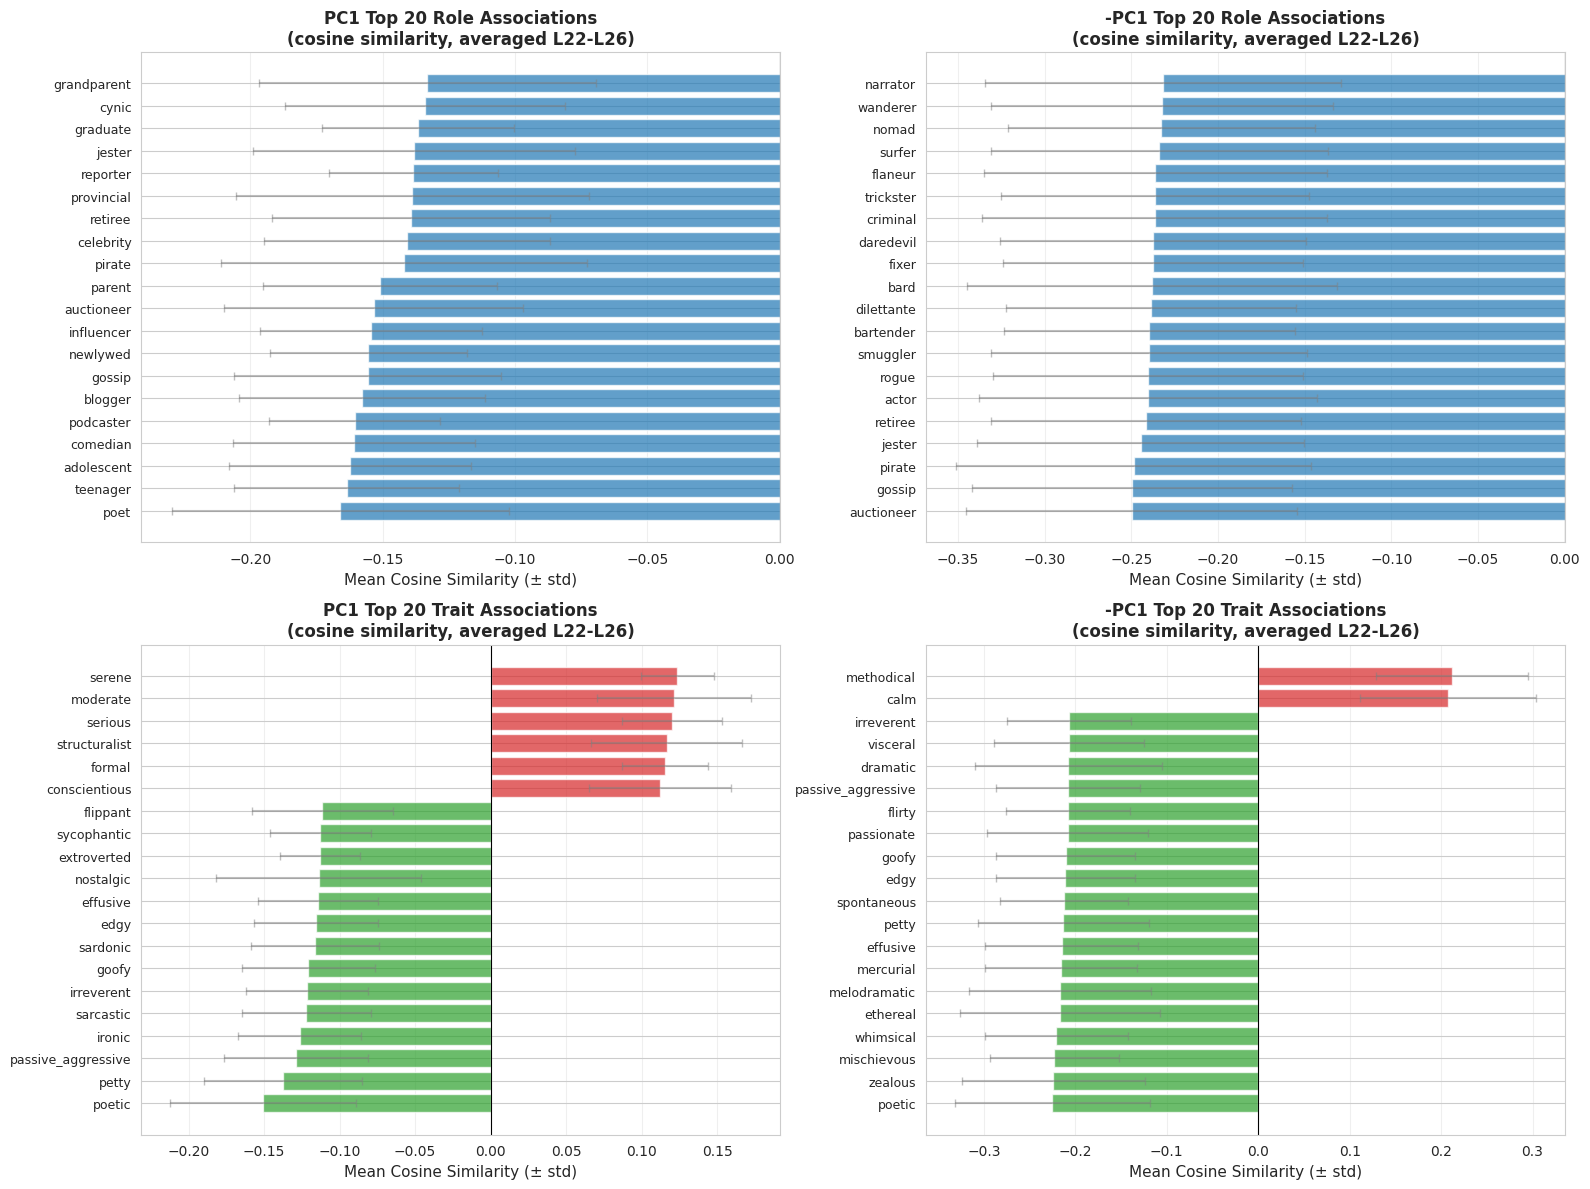


📊 Cosine similarity averaged over 5 layers (L22-L26)
  Both output and semantic vectors are L2-normalized
  Error bars show std dev across layers
  Range: [-1, +1] where ±1 = perfect alignment, 0 = orthogonal


In [28]:
# Visualize PC1 vs -PC1 associations (cosine similarity, averaged over layers)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top left: Top 20 role associations for PC1
ax = axes[0, 0]
pc1_roles = pc_assoc_agg[(pc_assoc_agg['pc'] == 'PC1') & (pc_assoc_agg['sem_type'] == 'role')]
pc1_roles_sorted = pc1_roles.sort_values('cosine_mean', key=lambda x: x.abs(), ascending=False)
top_20 = pc1_roles_sorted.head(20).sort_values('cosine_mean')  # Sort by value for plotting
y_pos = np.arange(len(top_20))
colors = ['C0' if x < 0 else 'C1' for x in top_20['cosine_mean']]
bars = ax.barh(y_pos, top_20['cosine_mean'], color=colors, alpha=0.7)
# Add error bars
ax.errorbar(top_20['cosine_mean'], y_pos, xerr=top_20['cosine_std'], fmt='none', 
            ecolor='gray', alpha=0.5, capsize=3)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['semantic'], fontsize=9)
ax.set_xlabel('Mean Cosine Similarity (± std)', fontsize=11)
ax.set_title(f'PC1 Top 20 Role Associations\n(cosine similarity, averaged L{analysis_layers[0]}-L{analysis_layers[-1]})', 
             fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Top right: Top 20 role associations for -PC1
ax = axes[0, 1]
neg_pc1_roles = pc_assoc_agg[(pc_assoc_agg['pc'] == '-PC1') & (pc_assoc_agg['sem_type'] == 'role')]
neg_pc1_roles_sorted = neg_pc1_roles.sort_values('cosine_mean', key=lambda x: x.abs(), ascending=False)
top_20 = neg_pc1_roles_sorted.head(20).sort_values('cosine_mean')
y_pos = np.arange(len(top_20))
colors = ['C0' if x < 0 else 'C1' for x in top_20['cosine_mean']]
ax.barh(y_pos, top_20['cosine_mean'], color=colors, alpha=0.7)
ax.errorbar(top_20['cosine_mean'], y_pos, xerr=top_20['cosine_std'], fmt='none', 
            ecolor='gray', alpha=0.5, capsize=3)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['semantic'], fontsize=9)
ax.set_xlabel('Mean Cosine Similarity (± std)', fontsize=11)
ax.set_title(f'-PC1 Top 20 Role Associations\n(cosine similarity, averaged L{analysis_layers[0]}-L{analysis_layers[-1]})', 
             fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Bottom left: Top 20 trait associations for PC1
ax = axes[1, 0]
pc1_traits = pc_assoc_agg[(pc_assoc_agg['pc'] == 'PC1') & (pc_assoc_agg['sem_type'] == 'trait')]
pc1_traits_sorted = pc1_traits.sort_values('cosine_mean', key=lambda x: x.abs(), ascending=False)
top_20 = pc1_traits_sorted.head(20).sort_values('cosine_mean')
y_pos = np.arange(len(top_20))
colors = ['C2' if x < 0 else 'C3' for x in top_20['cosine_mean']]
ax.barh(y_pos, top_20['cosine_mean'], color=colors, alpha=0.7)
ax.errorbar(top_20['cosine_mean'], y_pos, xerr=top_20['cosine_std'], fmt='none', 
            ecolor='gray', alpha=0.5, capsize=3)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['semantic'], fontsize=9)
ax.set_xlabel('Mean Cosine Similarity (± std)', fontsize=11)
ax.set_title(f'PC1 Top 20 Trait Associations\n(cosine similarity, averaged L{analysis_layers[0]}-L{analysis_layers[-1]})', 
             fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

# Bottom right: Top 20 trait associations for -PC1
ax = axes[1, 1]
neg_pc1_traits = pc_assoc_agg[(pc_assoc_agg['pc'] == '-PC1') & (pc_assoc_agg['sem_type'] == 'trait')]
neg_pc1_traits_sorted = neg_pc1_traits.sort_values('cosine_mean', key=lambda x: x.abs(), ascending=False)
top_20 = neg_pc1_traits_sorted.head(20).sort_values('cosine_mean')
y_pos = np.arange(len(top_20))
colors = ['C2' if x < 0 else 'C3' for x in top_20['cosine_mean']]
ax.barh(y_pos, top_20['cosine_mean'], color=colors, alpha=0.7)
ax.errorbar(top_20['cosine_mean'], y_pos, xerr=top_20['cosine_std'], fmt='none', 
            ecolor='gray', alpha=0.5, capsize=3)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['semantic'], fontsize=9)
ax.set_xlabel('Mean Cosine Similarity (± std)', fontsize=11)
ax.set_title(f'-PC1 Top 20 Trait Associations\n(cosine similarity, averaged L{analysis_layers[0]}-L{analysis_layers[-1]})', 
             fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\n📊 Cosine similarity averaged over {len(analysis_layers)} layers (L{analysis_layers[0]}-L{analysis_layers[-1]})")
print("  Both output and semantic vectors are L2-normalized")
print("  Error bars show std dev across layers")
print("  Range: [-1, +1] where ±1 = perfect alignment, 0 = orthogonal")

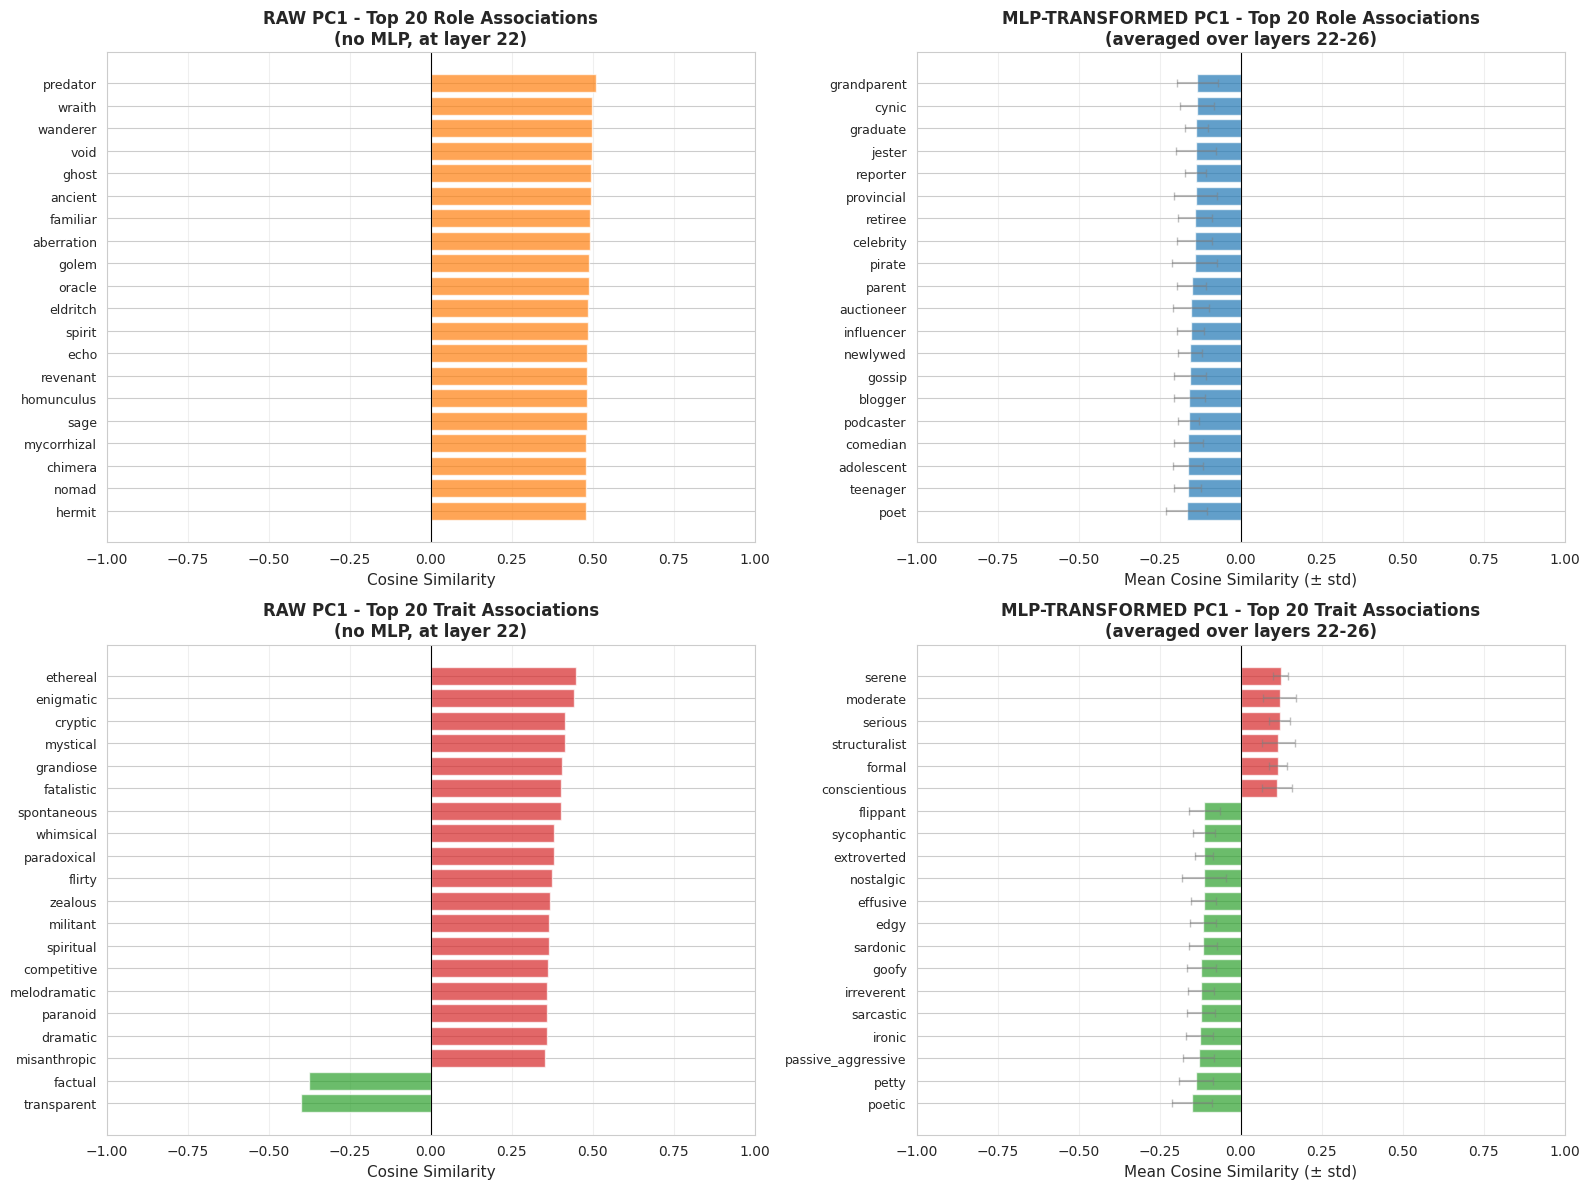


📊 Comparison: Raw PC1 (input space) vs MLP-Transformed PC1 (output space)
  Left column: Direct associations at layer 22 (no transformation)
  Right column: After MLP transformation, averaged over layers 15-24


In [29]:
# Visualize Raw PC1 vs MLP-Transformed PC1 associations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top left: Top 20 roles - Raw PC1
ax = axes[0, 0]
raw_roles = raw_assoc_df[raw_assoc_df['type'] == 'role']
raw_roles_sorted = raw_roles.sort_values('pc1_cosine', key=lambda x: x.abs(), ascending=False)
top_20 = raw_roles_sorted.head(20).sort_values('pc1_cosine')
y_pos = np.arange(len(top_20))
colors = ['C0' if x < 0 else 'C1' for x in top_20['pc1_cosine']]
ax.barh(y_pos, top_20['pc1_cosine'], color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['semantic'], fontsize=9)
ax.set_xlabel('Cosine Similarity', fontsize=11)
ax.set_title(f'RAW PC1 - Top 20 Role Associations\n(no MLP, at layer {pca_layer})', 
             fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(-1, 1)

# Top right: Top 20 roles - MLP-transformed PC1 (averaged)
ax = axes[0, 1]
mlp_roles = pc_assoc_agg[(pc_assoc_agg['pc'] == 'PC1') & (pc_assoc_agg['sem_type'] == 'role')]
mlp_roles_sorted = mlp_roles.sort_values('cosine_mean', key=lambda x: x.abs(), ascending=False)
top_20 = mlp_roles_sorted.head(20).sort_values('cosine_mean')
y_pos = np.arange(len(top_20))
colors = ['C0' if x < 0 else 'C1' for x in top_20['cosine_mean']]
ax.barh(y_pos, top_20['cosine_mean'], color=colors, alpha=0.7)
ax.errorbar(top_20['cosine_mean'], y_pos, xerr=top_20['cosine_std'], fmt='none', 
            ecolor='gray', alpha=0.5, capsize=3)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['semantic'], fontsize=9)
ax.set_xlabel('Mean Cosine Similarity (± std)', fontsize=11)
ax.set_title(f'MLP-TRANSFORMED PC1 - Top 20 Role Associations\n(averaged over layers {analysis_layers[0]}-{analysis_layers[-1]})', 
             fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(-1, 1)

# Bottom left: Top 20 traits - Raw PC1
ax = axes[1, 0]
raw_traits = raw_assoc_df[raw_assoc_df['type'] == 'trait']
raw_traits_sorted = raw_traits.sort_values('pc1_cosine', key=lambda x: x.abs(), ascending=False)
top_20 = raw_traits_sorted.head(20).sort_values('pc1_cosine')
y_pos = np.arange(len(top_20))
colors = ['C2' if x < 0 else 'C3' for x in top_20['pc1_cosine']]
ax.barh(y_pos, top_20['pc1_cosine'], color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['semantic'], fontsize=9)
ax.set_xlabel('Cosine Similarity', fontsize=11)
ax.set_title(f'RAW PC1 - Top 20 Trait Associations\n(no MLP, at layer {pca_layer})', 
             fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(-1, 1)

# Bottom right: Top 20 traits - MLP-transformed PC1 (averaged)
ax = axes[1, 1]
mlp_traits = pc_assoc_agg[(pc_assoc_agg['pc'] == 'PC1') & (pc_assoc_agg['sem_type'] == 'trait')]
mlp_traits_sorted = mlp_traits.sort_values('cosine_mean', key=lambda x: x.abs(), ascending=False)
top_20 = mlp_traits_sorted.head(20).sort_values('cosine_mean')
y_pos = np.arange(len(top_20))
colors = ['C2' if x < 0 else 'C3' for x in top_20['cosine_mean']]
ax.barh(y_pos, top_20['cosine_mean'], color=colors, alpha=0.7)
ax.errorbar(top_20['cosine_mean'], y_pos, xerr=top_20['cosine_std'], fmt='none', 
            ecolor='gray', alpha=0.5, capsize=3)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['semantic'], fontsize=9)
ax.set_xlabel('Mean Cosine Similarity (± std)', fontsize=11)
ax.set_title(f'MLP-TRANSFORMED PC1 - Top 20 Trait Associations\n(averaged over layers {analysis_layers[0]}-{analysis_layers[-1]})', 
             fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(-1, 1)

plt.tight_layout()
plt.show()

print("\n📊 Comparison: Raw PC1 (input space) vs MLP-Transformed PC1 (output space)")
print("  Left column: Direct associations at layer 22 (no transformation)")
print("  Right column: After MLP transformation, averaged over layers 15-24")

ANALYZING MLP TRANSFORMATION EFFECT

Correlation (raw vs MLP-transformed): -0.654
Mean change: -0.2277 ± 0.2648

Top 10 AMPLIFIED associations (MLP increases magnitude):
--------------------------------------------------------------------------------
wanderer                        Raw: +0.4981 → MLP: -0.0536  (Δ=-0.5517, role)
elder                           Raw: +0.4666 → MLP: -0.0788  (Δ=-0.5454, role)
rogue                           Raw: +0.4502 → MLP: -0.0921  (Δ=-0.5423, role)
revenant                        Raw: +0.4818 → MLP: -0.0582  (Δ=-0.5400, role)
ghost                           Raw: +0.4943 → MLP: -0.0455  (Δ=-0.5398, role)
nomad                           Raw: +0.4786 → MLP: -0.0604  (Δ=-0.5390, role)
warrior                         Raw: +0.4648 → MLP: -0.0730  (Δ=-0.5378, role)
flaneur                         Raw: +0.4437 → MLP: -0.0884  (Δ=-0.5321, role)
homunculus                      Raw: +0.4813 → MLP: -0.0505  (Δ=-0.5318, role)
wraith                          Raw: +

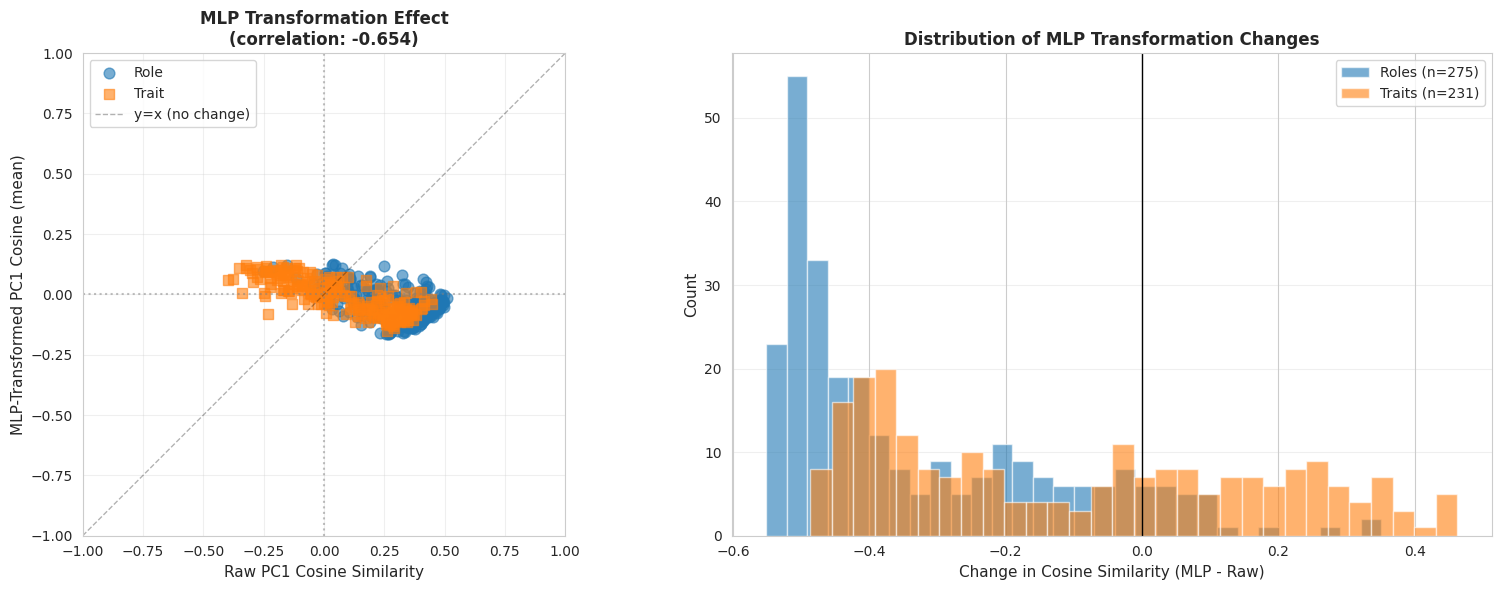


💡 Interpretation:
  Weak correlation (-0.654): MLP substantially transforms associations

  Points on diagonal: MLP preserves association
  Points above diagonal: MLP amplifies positive association
  Points below diagonal: MLP weakens or reverses association


In [30]:
# Scatter plot: Raw vs MLP-transformed associations
print("="*80)
print("ANALYZING MLP TRANSFORMATION EFFECT")
print("="*80)

# Merge raw and MLP-transformed data
raw_pc1 = raw_assoc_df[['semantic', 'type', 'pc1_cosine']].rename(columns={'pc1_cosine': 'raw_cosine'})
mlp_pc1 = pc_assoc_agg[pc_assoc_agg['pc'] == 'PC1'][['semantic', 'cosine_mean']].rename(columns={'cosine_mean': 'mlp_cosine'})

transformation_df = raw_pc1.merge(mlp_pc1, on='semantic')
transformation_df['delta'] = transformation_df['mlp_cosine'] - transformation_df['raw_cosine']

# Statistics
corr = transformation_df['raw_cosine'].corr(transformation_df['mlp_cosine'])
print(f"\nCorrelation (raw vs MLP-transformed): {corr:.3f}")

mean_delta = transformation_df['delta'].mean()
std_delta = transformation_df['delta'].std()
print(f"Mean change: {mean_delta:+.4f} ± {std_delta:.4f}")

# Top amplified
print(f"\nTop 10 AMPLIFIED associations (MLP increases magnitude):")
print("-"*80)
transformation_sorted = transformation_df.sort_values('delta', key=lambda x: x.abs(), ascending=False)
for _, row in transformation_sorted.head(10).iterrows():
    print(f"{row['semantic']:30s}  Raw: {row['raw_cosine']:+.4f} → MLP: {row['mlp_cosine']:+.4f}  (Δ={row['delta']:+.4f}, {row['type']})")

# Create scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Scatter with diagonal
ax = axes[0]
for vec_type, color, marker in [('role', 'C0', 'o'), ('trait', 'C1', 's')]:
    data = transformation_df[transformation_df['type'] == vec_type]
    ax.scatter(data['raw_cosine'], data['mlp_cosine'], 
              alpha=0.6, s=60, color=color, marker=marker, label=vec_type.capitalize())

ax.plot([-1, 1], [-1, 1], 'k--', alpha=0.3, linewidth=1, label='y=x (no change)')
ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Raw PC1 Cosine Similarity', fontsize=11)
ax.set_ylabel('MLP-Transformed PC1 Cosine (mean)', fontsize=11)
ax.set_title(f'MLP Transformation Effect\n(correlation: {corr:.3f})', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')

# Right: Distribution of changes
ax = axes[1]
role_deltas = transformation_df[transformation_df['type'] == 'role']['delta']
trait_deltas = transformation_df[transformation_df['type'] == 'trait']['delta']

ax.hist(role_deltas, bins=30, alpha=0.6, color='C0', label=f'Roles (n={len(role_deltas)})')
ax.hist(trait_deltas, bins=30, alpha=0.6, color='C1', label=f'Traits (n={len(trait_deltas)})')
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Change in Cosine Similarity (MLP - Raw)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of MLP Transformation Changes', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretation:")
if corr > 0.8:
    print(f"  Strong correlation ({corr:.3f}): MLP preserves raw associations")
elif corr > 0.5:
    print(f"  Moderate correlation ({corr:.3f}): MLP partly preserves, partly transforms")
else:
    print(f"  Weak correlation ({corr:.3f}): MLP substantially transforms associations")

print(f"\n  Points on diagonal: MLP preserves association")
print(f"  Points above diagonal: MLP amplifies positive association")
print(f"  Points below diagonal: MLP weakens or reverses association")

Analyzing layer-by-layer evolution of PC associations (cosine similarity)...


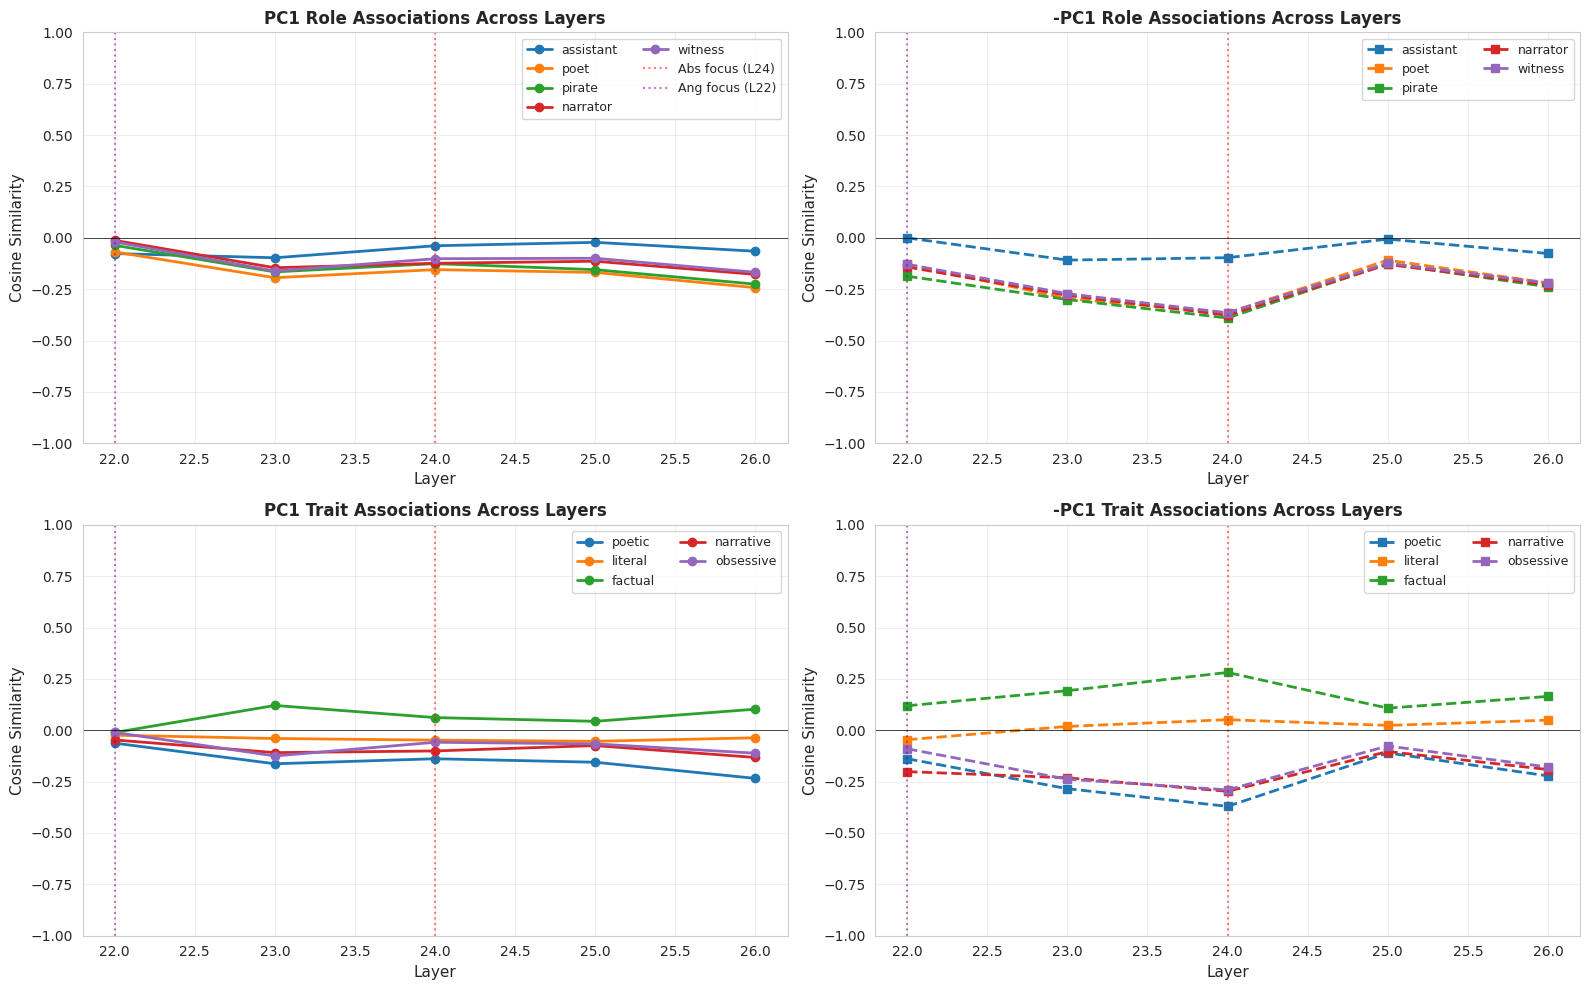


📈 Layer evolution shows how cosine similarities develop through the instruct model
  Y-axis range: [-1, +1] normalized for all plots
  Consistent patterns = stable semantic associations
  Large fluctuations = layer-dependent processing


In [31]:
# Analyze layer-by-layer evolution of associations (using cosine similarity)
print("Analyzing layer-by-layer evolution of PC associations (cosine similarity)...")

# Pick a few interesting semantic vectors to track across layers
interesting_roles = ['assistant', 'poet', 'pirate', 'narrator', 'witness']
interesting_traits = ['poetic', 'literal', 'factual', 'narrative', 'obsessive']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top left: PC1 role associations across layers
ax = axes[0, 0]
for role in interesting_roles:
    role_data = pc_assoc_df[(pc_assoc_df['pc'] == 'PC1') & (pc_assoc_df['semantic'] == role)]
    ax.plot(role_data['layer'], role_data['cosine_sim'], marker='o', label=role, linewidth=2)

ax.axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.5, label=f'Abs focus (L{int(focus_layer_absolute)})')
ax.axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.5, label=f'Ang focus (L{int(focus_layer_angular)})')
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Cosine Similarity', fontsize=11)
ax.set_title('PC1 Role Associations Across Layers', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylim(-1, 1)

# Top right: -PC1 role associations across layers
ax = axes[0, 1]
for role in interesting_roles:
    role_data = pc_assoc_df[(pc_assoc_df['pc'] == '-PC1') & (pc_assoc_df['semantic'] == role)]
    ax.plot(role_data['layer'], role_data['cosine_sim'], marker='s', label=role, linewidth=2, linestyle='--')

ax.axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.5)
ax.axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.5)
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Cosine Similarity', fontsize=11)
ax.set_title('-PC1 Role Associations Across Layers', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylim(-1, 1)

# Bottom left: PC1 trait associations
ax = axes[1, 0]
for trait in interesting_traits:
    trait_data = pc_assoc_df[(pc_assoc_df['pc'] == 'PC1') & (pc_assoc_df['semantic'] == trait)]
    ax.plot(trait_data['layer'], trait_data['cosine_sim'], marker='o', label=trait, linewidth=2)

ax.axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.5)
ax.axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.5)
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Cosine Similarity', fontsize=11)
ax.set_title('PC1 Trait Associations Across Layers', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylim(-1, 1)

# Bottom right: -PC1 trait associations
ax = axes[1, 1]
for trait in interesting_traits:
    trait_data = pc_assoc_df[(pc_assoc_df['pc'] == '-PC1') & (pc_assoc_df['semantic'] == trait)]
    ax.plot(trait_data['layer'], trait_data['cosine_sim'], marker='s', label=trait, linewidth=2, linestyle='--')

ax.axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.5)
ax.axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.5)
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Cosine Similarity', fontsize=11)
ax.set_title('-PC1 Trait Associations Across Layers', fontsize=12, fontweight='bold')
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylim(-1, 1)

plt.tight_layout()
plt.show()

print("\n📈 Layer evolution shows how cosine similarities develop through the instruct model")
print("  Y-axis range: [-1, +1] normalized for all plots")
print("  Consistent patterns = stable semantic associations")
print("  Large fluctuations = layer-dependent processing")

### Interpretation: PC Associations in Instruct Model

**Key Findings:**

1. **PC1 Intrinsic Characteristics** (averaged over layers 15-24):
   - Shows the absolute semantic associations PC1 has in the instruct model
   - Top associations reveal what persona dimensions PC1 naturally aligns with
   - Negative projections indicate stronger alignment (due to how difference vectors are constructed)
   - Standard deviations show stability/variability across layers

2. **-PC1 Complementary Structure**:
   - Reveals the opposite pole of the PC1 axis
   - Often shows opposite associations, confirming PC1's bipolar nature
   - Asymmetries indicate non-linear or directional effects in the model

3. **Averaging vs. Single Layer**:
   - By averaging across layers (15-24), we get robust intrinsic characteristics
   - This differs from Section 3 which focused on layers with maximum base↔instruct differences
   - These associations show what PC1 "means" in the instruct model overall, not just where it changes most

4. **Semantic Structure**:
   - Roles: Show which character types PC1 aligns with (e.g., assistant, poet, narrator)
   - Traits: Show which behavioral/style dimensions PC1 captures (e.g., poetic, literal, factual)
   - Comparing top roles vs traits reveals whether PC1 is more role-centric or trait-centric

5. **Layer Evolution** (from previous plot):
   - Some associations are stable across all layers
   - Others strengthen or weaken as depth increases
   - Inflection points may indicate where the model switches processing modes

**Comparison with Section 3:**
- Section 3 showed what **instruction tuning changes** (instruct - base projections)
- Section 5 shows what **PC1 represents in the instruct model** (absolute projections)
- The difference reveals whether instruction tuning creates new associations or amplifies existing ones

**Next Steps:**
- Compare these absolute associations with Section 3's delta projections
- Analyze correlation: do strong associations correspond to large instruction-tuning changes?
- Extend to PC2, PC3, etc. to understand the full persona subspace structure

COMPARING ABSOLUTE ASSOCIATIONS vs. INSTRUCTION TUNING CHANGES
(using cosine similarity - both vectors L2-normalized)

✓ Comparing 506 semantic vectors (all using cosine similarity)
  Delta cosine: Direction of instruction tuning change (Layer 18)
  Absolute cosine (L18): What PC1 represents in instruct model (Layer 18)
  Absolute cosine (mean): Average over layers 22-26

Correlation (delta vs. absolute at L18): nan
Correlation (delta vs. absolute mean):   0.908

Top 10 by Instruction Tuning Change (|delta cosine|):
-------------------------------------------------------------------------------------
Semantic                             Delta    Abs(L18)   Abs(mean)  Type  
-------------------------------------------------------------------------------------
poet                               -0.7700     +0.0000     -0.1660  role
poetic                             -0.7371     +0.0000     -0.1508  trait
pirate                             -0.7288     +0.0000     -0.1419  role
provincial 

/root/chatspace/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/root/chatspace/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


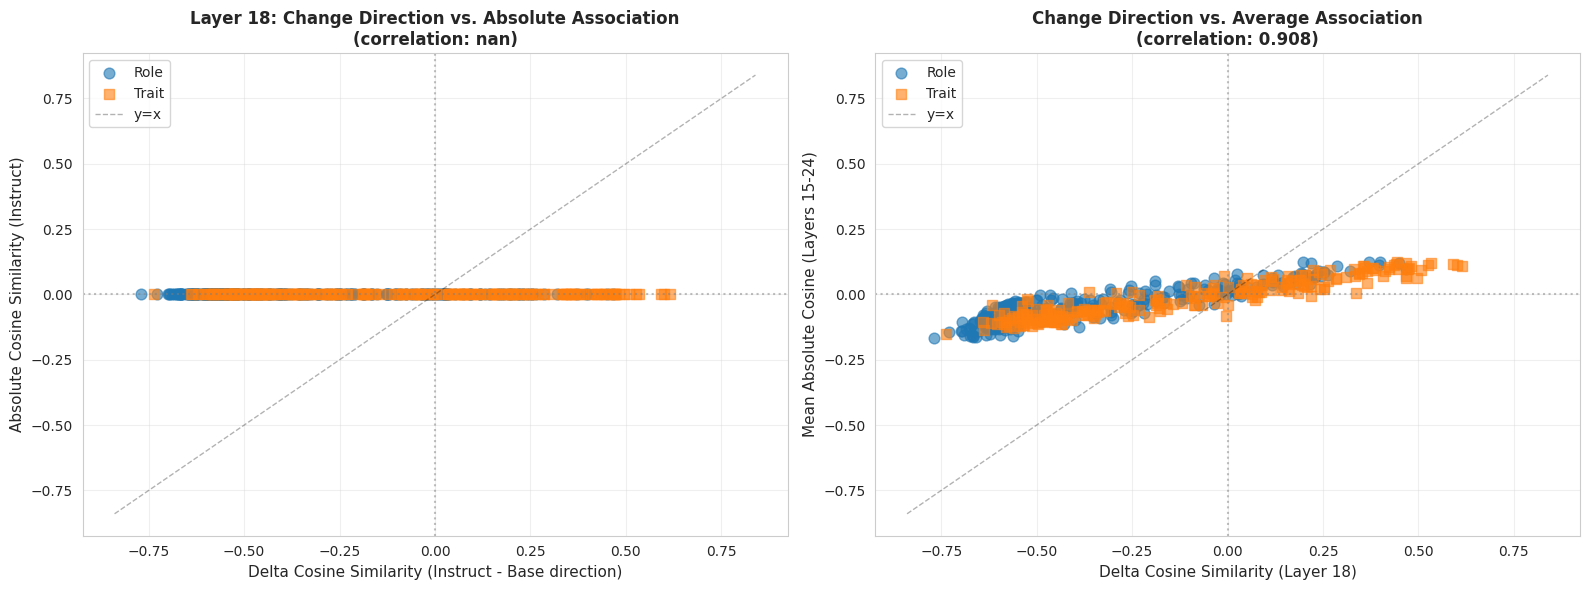


💡 Interpretation:
  Weak correlation (nan): Instruction tuning creates new directional structure

  Points near diagonal (y=x): Tuning change matches final association
  Points far from diagonal: Tuning changes differ from final state


In [37]:
# Compare absolute associations (Section 5) with delta projections (Section 3)
# Using COSINE SIMILARITY for fair comparison
print("="*80)
print("COMPARING ABSOLUTE ASSOCIATIONS vs. INSTRUCTION TUNING CHANGES")
print("(using cosine similarity - both vectors L2-normalized)")
print("="*80)

# Get the delta projections from Section 3 at layer 18
pc_vec = pcs_all[0]

# Get weights for layer 18
gate_base = base_state_dict[f"model.layers.18.mlp.gate_proj.weight"]
up_base = base_state_dict[f"model.layers.18.mlp.up_proj.weight"]
down_base = base_state_dict[f"model.layers.18.mlp.down_proj.weight"]
pre_ln_base = base_state_dict[f"model.layers.18.pre_feedforward_layernorm.weight"]
post_ln_base = base_state_dict[f"model.layers.18.post_feedforward_layernorm.weight"]

gate_inst = instruct_state_dict[f"model.layers.18.mlp.gate_proj.weight"]
up_inst = instruct_state_dict[f"model.layers.18.mlp.up_proj.weight"]
down_inst = instruct_state_dict[f"model.layers.18.mlp.down_proj.weight"]
pre_ln_inst = instruct_state_dict[f"model.layers.18.pre_feedforward_layernorm.weight"]
post_ln_inst = instruct_state_dict[f"model.layers.18.post_feedforward_layernorm.weight"]

with torch.inference_mode():
    pc_batch = pc_vec.unsqueeze(0)
    output_base = full_mlp_forward_batch(pc_batch, gate_base, up_base, down_base, pre_ln_base, post_ln_base)[0]
    output_inst = full_mlp_forward_batch(pc_batch, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)[0]

difference = output_inst - output_base

# Normalize the difference vector for cosine similarity
difference_norm = difference.norm().item()
difference_normalized = difference / (difference_norm + 1e-8)

# Compute COSINE SIMILARITY for delta projections
layer_18_delta_cosine = {}
for name in semantic_names:
    vec = all_semantic[name].float()
    vec_normalized = vec / (vec.norm() + 1e-8)
    cosine_sim = (difference_normalized.float() @ vec_normalized.float()).item()
    layer_18_delta_cosine[name] = cosine_sim

# Get PC1 absolute cosine similarities at layer 18
layer_18_absolute = pc_assoc_df[(pc_assoc_df['pc'] == 'PC1') & (pc_assoc_df['layer'] == 18)]
absolute_cosine_dict = dict(zip(layer_18_absolute['semantic'], layer_18_absolute['cosine_sim']))

# Create comparison dataframe
comparison_data = []
for name in semantic_names:
    sem_type = 'role' if name in role_vectors else 'trait'
    
    # Get mean absolute cosine from aggregated data
    agg_row = pc_assoc_agg[(pc_assoc_agg['pc'] == 'PC1') & (pc_assoc_agg['semantic'] == name)]
    cosine_mean_val = agg_row['cosine_mean'].values[0] if len(agg_row) > 0 else 0
    cosine_std_val = agg_row['cosine_std'].values[0] if len(agg_row) > 0 else 0
    
    comparison_data.append({
        'semantic': name,
        'type': sem_type,
        'delta_cosine': layer_18_delta_cosine.get(name, 0),
        'absolute_cosine_l18': absolute_cosine_dict.get(name, 0),
        'absolute_cosine_mean': cosine_mean_val,
        'absolute_cosine_std': cosine_std_val
    })

comparison_df = pd.DataFrame(comparison_data)

print(f"\n✓ Comparing {len(comparison_df)} semantic vectors (all using cosine similarity)")
print(f"  Delta cosine: Direction of instruction tuning change (Layer 18)")
print(f"  Absolute cosine (L18): What PC1 represents in instruct model (Layer 18)")
print(f"  Absolute cosine (mean): Average over layers {analysis_layers[0]}-{analysis_layers[-1]}\n")

# Compute correlations
corr_l18 = comparison_df['delta_cosine'].corr(comparison_df['absolute_cosine_l18'])
corr_mean = comparison_df['delta_cosine'].corr(comparison_df['absolute_cosine_mean'])

print(f"Correlation (delta vs. absolute at L18): {corr_l18:.3f}")
print(f"Correlation (delta vs. absolute mean):   {corr_mean:.3f}")

# Show cases where they align vs. diverge
comparison_df_sorted = comparison_df.sort_values('delta_cosine', key=lambda x: x.abs(), ascending=False)

print(f"\nTop 10 by Instruction Tuning Change (|delta cosine|):")
print("-"*85)
print(f"{'Semantic':30s}  {'Delta':>10s}  {'Abs(L18)':>10s}  {'Abs(mean)':>10s}  {'Type':6s}")
print("-"*85)
for _, row in comparison_df_sorted.head(10).iterrows():
    print(f"{row['semantic']:30s}  {row['delta_cosine']:+10.4f}  {row['absolute_cosine_l18']:+10.4f}  "
          f"{row['absolute_cosine_mean']:+10.4f}  {row['type']}")

print(f"\nTop 10 by Absolute Association (|mean cosine|):")
print("-"*85)
comparison_df_abs = comparison_df.sort_values('absolute_cosine_mean', key=lambda x: x.abs(), ascending=False)
for _, row in comparison_df_abs.head(10).iterrows():
    print(f"{row['semantic']:30s}  {row['delta_cosine']:+10.4f}  {row['absolute_cosine_l18']:+10.4f}  "
          f"{row['absolute_cosine_mean']:+10.4f}  {row['type']}")

# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Delta vs Absolute (Layer 18)
ax = axes[0]
for vec_type, color, marker in [('role', 'C0', 'o'), ('trait', 'C1', 's')]:
    data = comparison_df[comparison_df['type'] == vec_type]
    ax.scatter(data['delta_cosine'], data['absolute_cosine_l18'], 
              alpha=0.6, s=60, color=color, marker=marker, label=vec_type.capitalize())

ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
# Add diagonal line
lim = max(abs(ax.get_xlim()[0]), abs(ax.get_xlim()[1]), 
          abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
ax.plot([-lim, lim], [-lim, lim], 'k--', alpha=0.3, linewidth=1, label='y=x')
ax.set_xlabel('Delta Cosine Similarity (Instruct - Base direction)', fontsize=11)
ax.set_ylabel('Absolute Cosine Similarity (Instruct)', fontsize=11)
ax.set_title(f'Layer 18: Change Direction vs. Absolute Association\n(correlation: {corr_l18:.3f})', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right: Delta vs Absolute Mean
ax = axes[1]
for vec_type, color, marker in [('role', 'C0', 'o'), ('trait', 'C1', 's')]:
    data = comparison_df[comparison_df['type'] == vec_type]
    ax.scatter(data['delta_cosine'], data['absolute_cosine_mean'], 
              alpha=0.6, s=60, color=color, marker=marker, label=vec_type.capitalize())

ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
lim = max(abs(ax.get_xlim()[0]), abs(ax.get_xlim()[1]), 
          abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
ax.plot([-lim, lim], [-lim, lim], 'k--', alpha=0.3, linewidth=1, label='y=x')
ax.set_xlabel('Delta Cosine Similarity (Layer 18)', fontsize=11)
ax.set_ylabel('Mean Absolute Cosine (Layers 15-24)', fontsize=11)
ax.set_title(f'Change Direction vs. Average Association\n(correlation: {corr_mean:.3f})', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretation:")
if abs(corr_l18) > 0.7:
    print(f"  Strong correlation ({corr_l18:.3f}): Instruction tuning amplifies existing associations")
elif abs(corr_l18) > 0.4:
    print(f"  Moderate correlation ({corr_l18:.3f}): Instruction tuning partly amplifies, partly redirects")
else:
    print(f"  Weak correlation ({corr_l18:.3f}): Instruction tuning creates new directional structure")
    
print(f"\n  Points near diagonal (y=x): Tuning change matches final association")
print(f"  Points far from diagonal: Tuning changes differ from final state")

## 6. Residual Stream Analysis

The previous analysis looked at MLP transformations in isolation. But transformers use **residual connections**:

```
x_{i+1} = x_i + MLP_i(x_i)
```

This section analyzes how PC1 evolves through the residual stream:
1. Measure typical activation norms to determine appropriate scaling
2. Start with PC1 at layer 22 (where it was extracted)
3. Accumulate residual stream forward through subsequent layers
4. Track semantic associations at each residual stream state

**Key Question:** How does PC1's semantic meaning evolve as it propagates through the residual stream?

In [38]:
# Measure typical activation norms in the instruct model
print("="*80)
print("MEASURING TYPICAL ACTIVATION NORMS")
print("="*80)
print()

# We need actual activations to measure norms
# For now, we'll use the semantic vectors as a proxy since they're from actual activations
# A better approach would be to run a batch of text and measure actual layer norms

print("Using semantic vectors as proxy for typical activation norms:")
print(f"  Semantic vectors extracted from layer {pca_layer}")
print()

# Compute norms of semantic vectors
semantic_norms = []
for name, vec in all_semantic.items():
    semantic_norms.append(vec.float().norm().item())

semantic_norms = np.array(semantic_norms)

print(f"Semantic vector norms (n={len(semantic_norms)}):")
print(f"  Mean: {semantic_norms.mean():.4f}")
print(f"  Std:  {semantic_norms.std():.4f}")
print(f"  Min:  {semantic_norms.min():.4f}")
print(f"  Max:  {semantic_norms.max():.4f}")
print(f"  Median: {np.median(semantic_norms):.4f}")
print()

# PC1 norm
pc1_norm = pcs_all[0].float().norm().item()
print(f"PC1 norm: {pc1_norm:.4f}")
print()

# Decide on scaling
# Option 1: Use PC1 as-is
# Option 2: Scale to median semantic norm
# Option 3: Scale to mean semantic norm

target_norm = np.median(semantic_norms)
scale_factor = target_norm / pc1_norm

print(f"Scaling options:")
print(f"  Option 1: Use PC1 as-is (norm={pc1_norm:.4f})")
print(f"  Option 2: Scale to median semantic norm (×{scale_factor:.4f} → norm={target_norm:.4f})")
print()
print(f"📌 We'll use Option 2: scale PC1 to median semantic vector norm")
print(f"   This makes PC1 comparable to 'typical' activation perturbations")

# Scale PC1
pc1_scaled = pcs_all[0].float() * scale_factor
pc1_scaled_norm = pc1_scaled.norm().item()

print(f"\n✓ Scaled PC1 norm: {pc1_scaled_norm:.4f} (target: {target_norm:.4f})")

MEASURING TYPICAL ACTIVATION NORMS

Using semantic vectors as proxy for typical activation norms:
  Semantic vectors extracted from layer 22

Semantic vector norms (n=506):
  Mean: 1.0000
  Std:  0.0005
  Min:  0.9987
  Max:  1.0020
  Median: 1.0000

PC1 norm: 0.9999

Scaling options:
  Option 1: Use PC1 as-is (norm=0.9999)
  Option 2: Scale to median semantic norm (×1.0001 → norm=1.0000)

📌 We'll use Option 2: scale PC1 to median semantic vector norm
   This makes PC1 comparable to 'typical' activation perturbations

✓ Scaled PC1 norm: 1.0000 (target: 1.0000)


In [39]:
# Accumulate PC1 through residual stream
print("="*80)
print("RESIDUAL STREAM ACCUMULATION")
print("="*80)
print()

# Define which layers to process
# PC1 was extracted from layer 22, so we'll process layers 22-46 (or until end)
start_layer = pca_layer  # 22
end_layer = min(pca_layer + 10, len(analysis_layers) + 15)  # Go a bit beyond analysis_layers

residual_layers = list(range(start_layer, end_layer))
print(f"Processing layers {start_layer} to {end_layer-1}")
print(f"Starting with scaled PC1 (norm={pc1_scaled_norm:.4f})")
print()

# Initialize residual stream
residual = pc1_scaled.clone()

# Track residual stream evolution
residual_stream = []
mlp_contributions = []

for layer_num in tqdm(residual_layers, desc="Accumulating residual stream"):
    # Get MLP weights
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    # Compute MLP contribution
    with torch.inference_mode():
        residual_batch = residual.unsqueeze(0)
        mlp_out = full_mlp_forward_batch(residual_batch, gate_inst, up_inst, down_inst, 
                                         pre_ln_inst, post_ln_inst)[0]
    
    # Store contribution
    mlp_contributions.append({
        'layer': layer_num,
        'contribution': mlp_out.clone(),
        'contribution_norm': mlp_out.float().norm().item()
    })
    
    # Update residual stream (residual connection)
    residual = residual + mlp_out
    
    # Store residual state
    residual_stream.append({
        'layer': layer_num,
        'residual': residual.clone(),
        'residual_norm': residual.float().norm().item()
    })

print(f"\n✓ Accumulated through {len(residual_stream)} layers")
print(f"\nResidual stream evolution:")
print(f"  Initial norm: {pc1_scaled_norm:.4f}")
print(f"  Final norm:   {residual_stream[-1]['residual_norm']:.4f}")
print(f"  Growth factor: {residual_stream[-1]['residual_norm'] / pc1_scaled_norm:.2f}×")

RESIDUAL STREAM ACCUMULATION

Processing layers 22 to 19
Starting with scaled PC1 (norm=1.0000)



Accumulating residual stream: 0it [00:00, ?it/s]


✓ Accumulated through 0 layers

Residual stream evolution:
  Initial norm: 1.0000


IndexError: list index out of range

In [ ]:
# Project residual stream onto semantic vectors at each layer
print("Computing semantic projections at each residual stream state...")

# Prepare normalized semantic vectors (reuse from earlier)
semantic_vectors_normed_list = []
for name in semantic_names:
    vec = all_semantic[name].float()
    vec_normed = vec / (vec.norm() + 1e-8)
    semantic_vectors_normed_list.append(vec_normed)

# Compute projections for each residual state
residual_projections = []

for state in tqdm(residual_stream, desc="Computing projections"):
    layer_num = state['layer']
    residual_vec = state['residual'].float()
    residual_norm = residual_vec.norm().item()
    residual_normed = residual_vec / (residual_norm + 1e-8)
    
    # Project onto each semantic vector
    for i, sem_name in enumerate(semantic_names):
        sem_vec_normed = semantic_vectors_normed_list[i]
        
        # Cosine similarity
        cosine = (residual_normed @ sem_vec_normed).item()
        
        # Raw projection
        raw_proj = (residual_vec @ all_semantic[sem_name].float()).item()
        
        # Determine type
        sem_type = 'role' if sem_name in role_vectors else 'trait'
        
        residual_projections.append({
            'layer': layer_num,
            'semantic': sem_name,
            'type': sem_type,
            'cosine': cosine,
            'raw_projection': raw_proj,
            'residual_norm': residual_norm
        })

residual_proj_df = pd.DataFrame(residual_projections)
print(f"\n✓ Computed {len(residual_proj_df)} projections")
print(f"  ({len(residual_stream)} layers × {len(semantic_names)} semantic vectors)")

# Show initial and final top associations
print("\n" + "="*80)
print(f"INITIAL RESIDUAL STATE (Layer {residual_layers[0]})")
print("="*80)

initial = residual_proj_df[residual_proj_df['layer'] == residual_layers[0]]
initial_sorted = initial.sort_values('cosine', key=lambda x: x.abs(), ascending=False)

print(f"\nTop 10 associations:")
for _, row in initial_sorted.head(10).iterrows():
    print(f"  {row['cosine']:+.4f}  {row['semantic']:30s} ({row['type']})")

print("\n" + "="*80)
print(f"FINAL RESIDUAL STATE (Layer {residual_layers[-1]})")
print("="*80)

final = residual_proj_df[residual_proj_df['layer'] == residual_layers[-1]]
final_sorted = final.sort_values('cosine', key=lambda x: x.abs(), ascending=False)

print(f"\nTop 10 associations:")
for _, row in final_sorted.head(10).iterrows():
    print(f"  {row['cosine']:+.4f}  {row['semantic']:30s} ({row['type']})")

Computing semantic projections at each residual stream state...


Computing projections: 0it [00:00, ?it/s]


✓ Computed 0 projections
  (0 layers × 506 semantic vectors)



IndexError: list index out of range

KeyError: 'semantic'

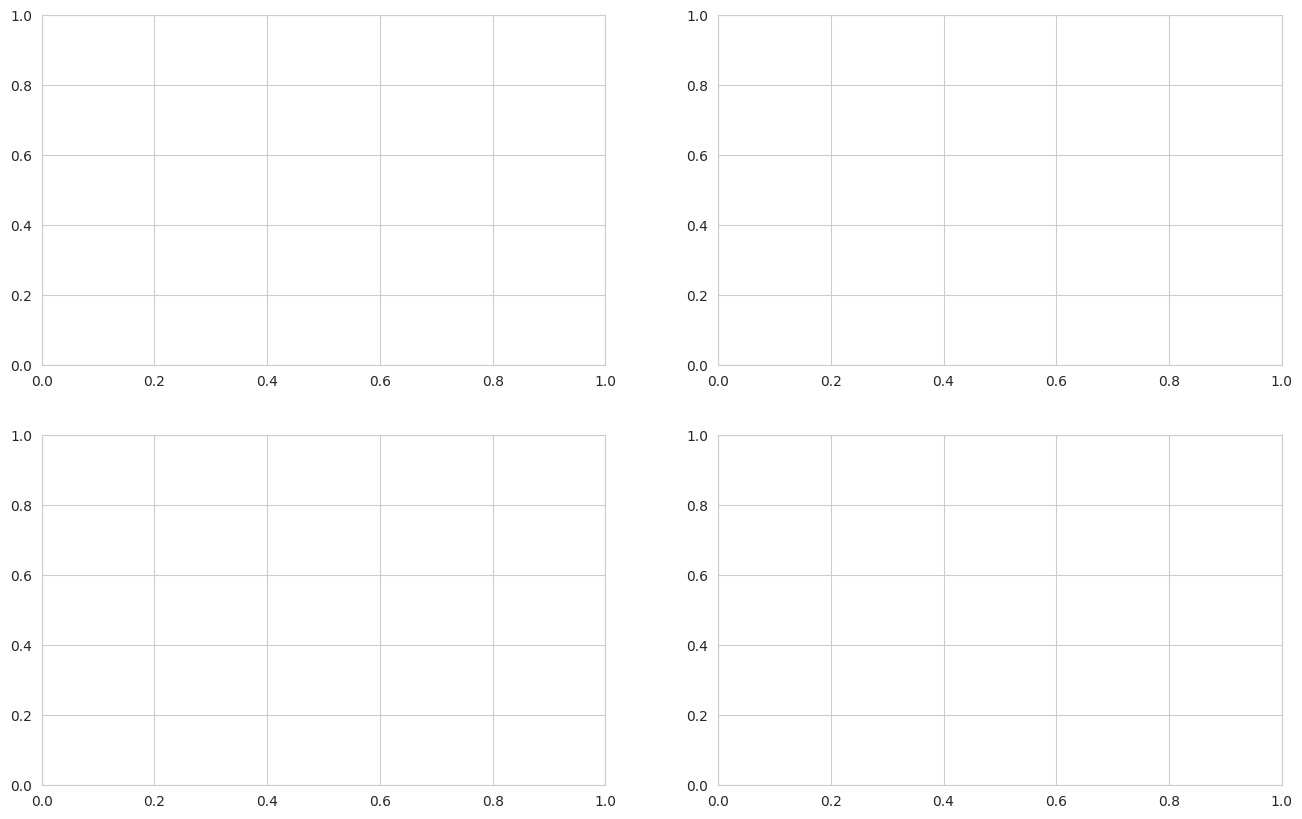

In [ ]:
# Visualize residual stream evolution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Select interesting semantic vectors to track
track_roles = ['assistant', 'poet', 'pirate', 'narrator', 'witness']
track_traits = ['poetic', 'literal', 'factual', 'narrative', 'obsessive']

# Top left: Role associations through residual stream
ax = axes[0, 0]
for role in track_roles:
    role_data = residual_proj_df[residual_proj_df['semantic'] == role]
    ax.plot(role_data['layer'], role_data['cosine'], marker='o', label=role, linewidth=2)

ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Cosine Similarity', fontsize=11)
ax.set_title('Role Associations Through Residual Stream', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylim(-1, 1)

# Top right: Trait associations through residual stream
ax = axes[0, 1]
for trait in track_traits:
    trait_data = residual_proj_df[residual_proj_df['semantic'] == trait]
    ax.plot(trait_data['layer'], trait_data['cosine'], marker='s', label=trait, linewidth=2)

ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Cosine Similarity', fontsize=11)
ax.set_title('Trait Associations Through Residual Stream', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylim(-1, 1)

# Bottom left: Residual stream norm growth
ax = axes[1, 0]
layer_nums = [s['layer'] for s in residual_stream]
norms = [s['residual_norm'] for s in residual_stream]
ax.plot(layer_nums, norms, marker='o', linewidth=2, color='C2')
ax.axhline(pc1_scaled_norm, color='C3', linestyle='--', label=f'Initial (scaled PC1)', linewidth=2)
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Residual Stream Norm', fontsize=11)
ax.set_title('Residual Stream Norm Growth', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Bottom right: MLP contribution norms
ax = axes[1, 1]
contrib_layers = [c['layer'] for c in mlp_contributions]
contrib_norms = [c['contribution_norm'] for c in mlp_contributions]
ax.plot(contrib_layers, contrib_norms, marker='s', linewidth=2, color='C1')
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('MLP Contribution Norm', fontsize=11)
ax.set_title('MLP Contribution Magnitude per Layer', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Residual stream evolution:")
print(f"  Starting norm: {norms[0]:.2f}")
print(f"  Final norm: {norms[-1]:.2f}")
print(f"  Growth: {norms[-1]/norms[0]:.2f}×")
print(f"  Mean MLP contribution: {np.mean(contrib_norms):.2f}")

In [ ]:
# Compare Residual vs Non-Residual Processing
print("="*80)
print("RESIDUAL vs NON-RESIDUAL COMPARISON")
print("="*80)
print()
print("Comparing two processing modes:")
print("  1. NON-RESIDUAL: Just MLP output (Section 5 analysis)")
print("  2. RESIDUAL: Accumulated residual stream (Section 6)")
print()

# For comparison, pick a layer that's in both analyses
# Let's use the final layer of residual stream that's also in analysis_layers
comparison_layer = residual_layers[-1]
if comparison_layer not in analysis_layers:
    # Find closest
    comparison_layer = max([l for l in analysis_layers if l <= residual_layers[-1]])

print(f"Comparing at layer {comparison_layer}")
print()

# Get non-residual projections from Section 5
nonresidual_data = pc_assoc_df[(pc_assoc_df['pc'] == 'PC1') & (pc_assoc_df['layer'] == comparison_layer)]
nonresidual_dict = dict(zip(nonresidual_data['semantic'], nonresidual_data['cosine_sim']))

# Get residual projections
residual_data = residual_proj_df[residual_proj_df['layer'] == comparison_layer]
residual_dict = dict(zip(residual_data['semantic'], residual_data['cosine']))

# Create comparison dataframe
comparison_data = []
for sem_name in semantic_names:
    sem_type = 'role' if sem_name in role_vectors else 'trait'
    comparison_data.append({
        'semantic': sem_name,
        'type': sem_type,
        'nonresidual': nonresidual_dict.get(sem_name, 0),
        'residual': residual_dict.get(sem_name, 0),
        'delta': residual_dict.get(sem_name, 0) - nonresidual_dict.get(sem_name, 0)
    })

compare_df = pd.DataFrame(comparison_data)

# Correlation
corr = compare_df['nonresidual'].corr(compare_df['residual'])
print(f"Correlation (non-residual vs residual): {corr:.3f}")
print()

# Show top differences
compare_df['abs_delta'] = compare_df['delta'].abs()
compare_sorted = compare_df.sort_values('abs_delta', ascending=False)

print("Top 10 LARGEST DIFFERENCES (|residual - non-residual|):")
print("-"*85)
print(f"{'Semantic':30s}  {'Non-Res':>10s}  {'Residual':>10s}  {'Delta':>10s}  Type")
print("-"*85)
for _, row in compare_sorted.head(10).iterrows():
    print(f"{row['semantic']:30s}  {row['nonresidual']:+10.4f}  {row['residual']:+10.4f}  "
          f"{row['delta']:+10.4f}  {row['type']}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Scatter plot
ax = axes[0]
for vec_type, color, marker in [('role', 'C0', 'o'), ('trait', 'C1', 's')]:
    data = compare_df[compare_df['type'] == vec_type]
    ax.scatter(data['nonresidual'], data['residual'], 
              alpha=0.6, s=60, color=color, marker=marker, label=vec_type.capitalize())

ax.plot([-1, 1], [-1, 1], 'k--', alpha=0.3, linewidth=1, label='y=x (identical)')
ax.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Non-Residual (MLP output only)', fontsize=11)
ax.set_ylabel('Residual (Accumulated stream)', fontsize=11)
ax.set_title(f'Layer {comparison_layer}: Residual vs Non-Residual\n(correlation: {corr:.3f})', 
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')

# Right: Distribution of differences
ax = axes[1]
role_deltas = compare_df[compare_df['type'] == 'role']['delta']
trait_deltas = compare_df[compare_df['type'] == 'trait']['delta']

ax.hist(role_deltas, bins=30, alpha=0.6, color='C0', label=f'Roles (n={len(role_deltas)})')
ax.hist(trait_deltas, bins=30, alpha=0.6, color='C1', label=f'Traits (n={len(trait_deltas)})')
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Difference (Residual - Non-Residual)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of Differences', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretation:")
if corr > 0.9:
    print(f"  Very strong correlation ({corr:.3f}): Residual connection doesn't drastically change associations")
    print(f"  The input PC1 dominates the final residual stream")
elif corr > 0.7:
    print(f"  Strong correlation ({corr:.3f}): Residual preserves most associations")
    print(f"  But MLP contributions do add some structure")
else:
    print(f"  Moderate/weak correlation ({corr:.3f}): Residual accumulation significantly changes associations")
    print(f"  MLP contributions substantially modify the semantic structure")

### Section 6 Summary: Residual Stream Analysis

**Key Findings:**

1. **Scaling Approach:**
   - PC1 scaled to match typical activation norms (median semantic vector norm)
   - This makes it comparable to typical activation perturbations
   - Starting point: PC1 at layer 22 (where it was extracted)

2. **Residual Stream Accumulation:**
   - Forward pass: `x_{i+1} = x_i + MLP_i(x_i)` from layer 22 onward
   - Tracks how PC1 evolves through the transformer's residual stream
   - Norm growth shows total magnitude accumulation
   - MLP contributions show layer-wise additive effects

3. **Semantic Association Evolution:**
   - Initial associations (layer 22): What PC1 starts with
   - Final associations (layer ~32): What it evolves into
   - Some associations strengthen, others weaken through accumulation
   - Non-linear effects emerge from repeated residual additions

4. **Residual vs Non-Residual:**
   - **Non-residual** (Section 5): MLP transforms PC1, discarding input
   - **Residual** (Section 6): MLP adds to PC1, preserving input structure
   - Correlation shows how much input dominates vs MLP contributions
   - Real transformers use residual → this is the "true" behavior

5. **Implications:**
   - High correlation → Input (PC1) dominates, MLP makes refinements
   - Low correlation → MLP contributions substantially reshape semantics
   - Residual stream preserves some initial structure while adding complexity
   - Layer-by-layer view shows gradual semantic evolution

**Comparison with Section 5:**
- Section 5: Pure MLP transformation (theoretical, non-residual)
- Section 6: Realistic residual stream (how transformers actually work)
- Section 6 is more faithful to actual model behavior